# imports

In [1]:
import pandas as pd
pd.set_option('display.float_format', '{:.10f}'.format)
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import seaborn as sns
rng = np.random.default_rng(seed=17)
from statsmodels.tsa.stattools import pacf, acf, adfuller
from statsmodels.stats.stattools import jarque_bera
from scipy.ndimage import shift
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split

results = pd.DataFrame(columns=['S', 'R^2', 'IKA', 'DW', 'MSE'])

results_2 = pd.DataFrame(columns=['S', 'R^2', 'IKA', 'DW', 'MSE'])

results_3 = pd.DataFrame(columns=['S', 'R^2', 'IKA', 'DW', 'MSE'])

RTSfn = pd.read_csv('RTSfn.txt', names=['RTSfn'], header=None)
rts2000 = pd.read_csv('2000rts1.txt', names=['rts2000'], header=None)
test = pd.read_csv('example_for_DW.txt', names=['example_for_DW'], header=None)

like_other = pd.read_csv('rts2.txt', names=['rts2'], header=None)

sns.set(rc={'figure.figsize':(14, 8)})

In [2]:
alpha = 0.05

print(f"alpha = {alpha}\n")
# ADF Test
print("==== Augmented Dickey–Fuller for RTSfn: ")
result = adfuller(RTSfn, autolag='AIC')
print(f'ADF Statistic: {result[0]:.4g}')
print(f'p-value: {result[1]:.4g}')
if result[1] < alpha:
    print("The process is stationary.")
else:
    print("The process is non-stationary.") 
    

print("\n==== Augmented Dickey–Fuller for rts2000: ")
result = adfuller(rts2000, autolag='AIC')
print(f'ADF Statistic: {result[0]:.4g}')
print(f'p-value: {result[1]:.4g}')
if result[1] < alpha:
    print("The process is stationary.")
else:
    print("The process is non-stationary.")

alpha = 0.05

==== Augmented Dickey–Fuller for RTSfn: 
ADF Statistic: 0.2967
p-value: 0.9772
The process is non-stationary.

==== Augmented Dickey–Fuller for rts2000: 
ADF Statistic: -1.442
p-value: 0.5621
The process is non-stationary.


In [3]:
class MLS:
    def __init__(self):
        self.coefs = []
    
    def fit(self, X, y):
        self.coefs.append(np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y))
        
    def predict(self, X):
        return np.dot(X, self.weights()).flatten()

    def weights(self):
        return np.array(self.coefs[-1])


In [4]:
def calculate_sma(data, window):
    return np.pad(np.convolve(data, np.ones(window) / window, mode='valid'), (window-1, 0), mode='constant')

In [5]:
def calculate_ema(data, window):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    
    return np.pad(out[window-1:], (window-1, 0), mode='constant')

In [6]:
def DW(res):
    return np.sum(np.diff(res, axis=0)*np.diff(res, axis=0)) / np.sum(res*res)

def metric_S(y_true, y_pred):
    return np.power((y_true-y_pred), 2).sum()

def metric_R_sq(y_true, y_pred):
    return np.var(y_pred)/np.var(y_true)

def metric_IKA(y_true, y_pred, params):
    return len(y_true)*np.log(np.power((y_true-y_pred), 2).sum()) + 2*(params[0]+params[1]+1)

def metric_MSE(y_true, y_pred):
    return (np.power((y_true-y_pred), 2).sum())/len(y_true)

def metric_RMSE(y_true, y_pred):
    return np.sqrt((np.power((y_true-y_pred), 2).sum())/len(y_true))

In [7]:
def add_results(df, y_true, y_pred):
    if isinstance(y_true, np.ndarray):
        return pd.concat([df, pd.DataFrame([{'S': metric_S(y_true, y_pred),
                                'R^2': metric_R_sq(y_true, y_pred),
                                'IKA': metric_IKA(y_true, y_pred, [1, 1]),
                                'DW': DW(y_true - y_pred),
                                'MSE': metric_MSE(y_true, y_pred),
                                'RMSE': metric_RMSE(y_true, y_pred)}])], axis=0, ignore_index=True)
    else:
        return pd.concat([df, pd.DataFrame([{'S': metric_S(y_true.values.flatten(), y_pred),
                                'R^2': metric_R_sq(y_true.values.flatten(), y_pred),
                                'IKA': metric_IKA(y_true.values.flatten(), y_pred, [1, 1]),
                                'DW': DW(y_true.values.flatten() - y_pred),
                                'MSE': metric_MSE(y_true.values.flatten(), y_pred),
                                'RMSE': metric_RMSE(y_true.values.flatten(), y_pred)}])], axis=0, ignore_index=True)

# Durbіn-Watson

In [8]:
DW(test.values)

1.2288100804239723

# RTSfn

## Hist and stats for time series data

,RTSfn
count,178.0000000000
mean,623.6236516854
std,88.7041629010
min,309.3900000000
25%,604.3350000000
50%,633.6700000000
75%,678.1725000000
max,796.2100000000
jarque_bera,0.8991790788
p-value,0.6378899266


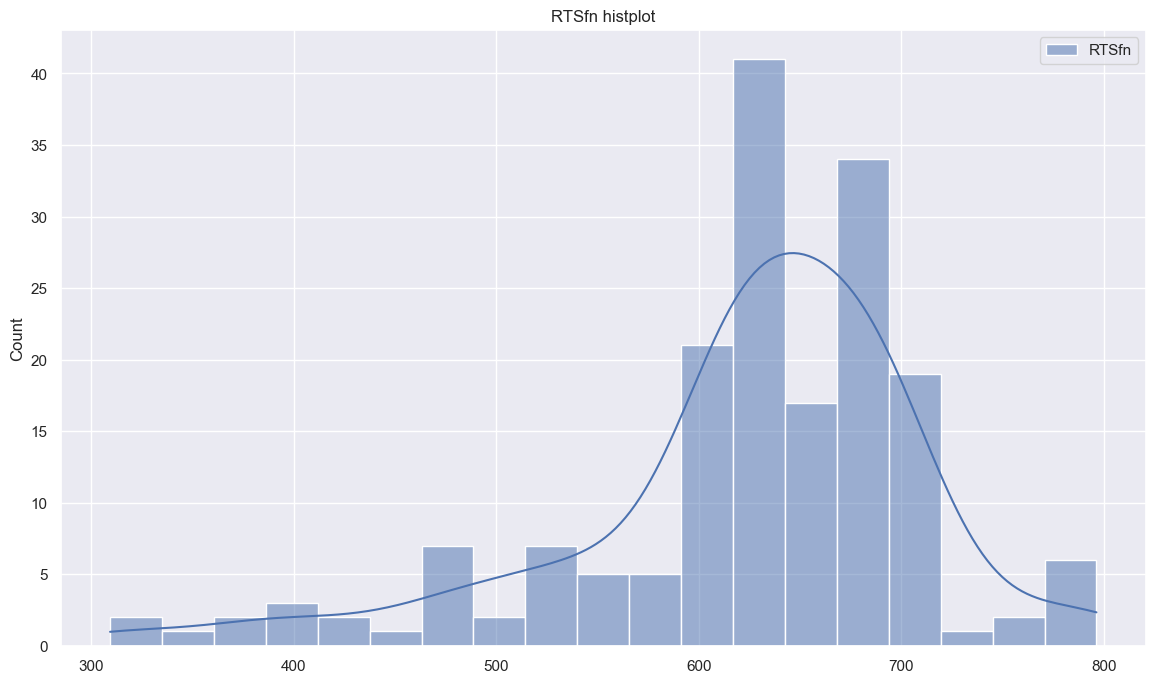

In [9]:
sns.histplot(RTSfn, kde=True).set(title='RTSfn histplot')

rtsfn_stats = RTSfn.describe()

stats_values = jarque_bera(rtsfn_stats)
index_values = ['jarque_bera', 'p-value', 'skew', 'kurtosis']
for idx, value in zip(index_values, stats_values):
    rtsfn_stats.loc[idx, 'RTSfn'] = value

rtsfn_stats

З цього p-value ми можемо зробити висновок, що ми не можемо відкинути нашу "Нуль" - гіпотезу - дані нормально розподілені

## Finding p for AR

c:\Users\Kidma\anaconda3\envs\fullds\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


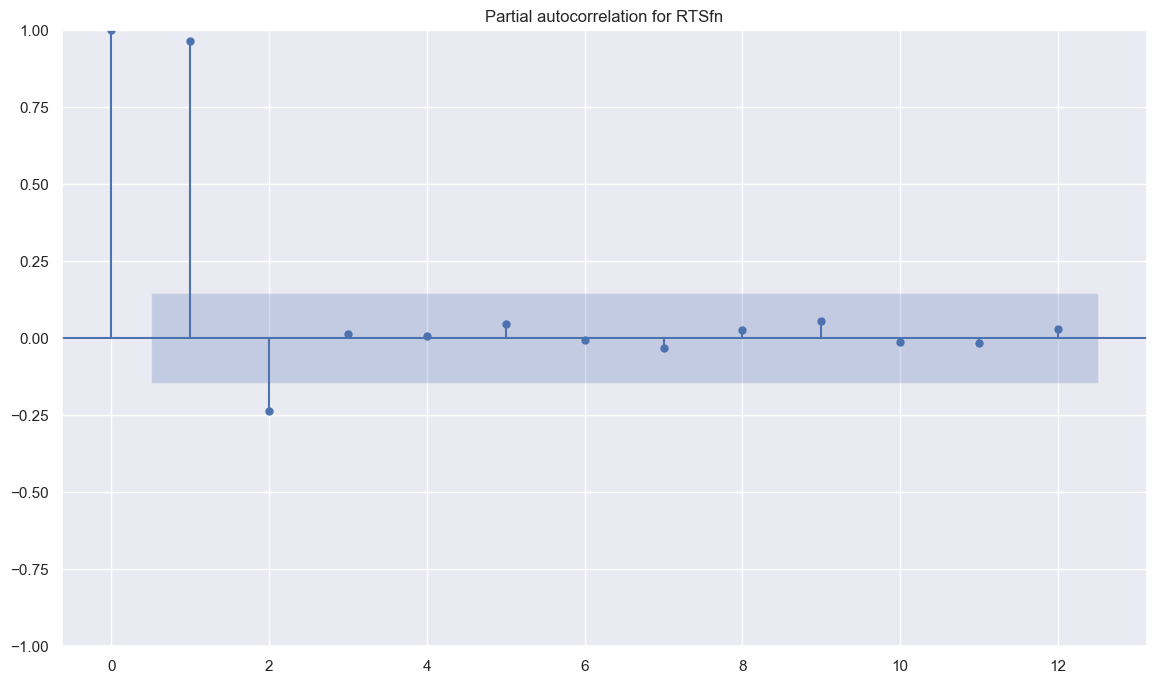

,autocorr,pacf
0,0.9596689675,0.9650908261
1,0.9048214684,-0.2375633218
2,0.8498453104,0.0111279798
3,0.7979560892,0.0063390725
4,0.7521555424,0.0455353131
5,0.7099451946,-0.0077856942
6,0.6681882605,-0.0341880314
7,0.6294990882,0.0268335498
8,0.5966814828,0.0540140302
9,0.5665437560,-0.0122048385


In [10]:
pacf_RTSfn = pd.DataFrame({'autocorr': acf(RTSfn['RTSfn'], nlags=12)[1:],
                            'pacf': pacf(RTSfn, nlags=12)[1:]})
plot_pacf(RTSfn, title='Partial autocorrelation for RTSfn', lags=12)
plt.show()
pacf_RTSfn

З цього ми бачимо, що як p нам потрібно взяти 2 тому що це останнє статистично значиме значення (не входить до синього прямокутнику)

## Створення АРКС по залишкам АР(р) моделі

### q for MA

Додами наші лаги до датасету

In [11]:
y_k_1 = shift(RTSfn['RTSfn'], 1, cval=0)
y_k_2 = shift(RTSfn['RTSfn'], 2, cval=0)

X_rtsfn_1 = pd.DataFrame({'a_0': np.ones(len(y_k_1)), 'y_k-1': y_k_1, 'y_k-2': y_k_2})

X_rtsfn_1

,a_0,y_k-1,y_k-2
0,1.0000000000,0.0000000000,0.0000000000
1,1.0000000000,786.3100000000,0.0000000000
2,1.0000000000,788.7900000000,786.3100000000
3,1.0000000000,792.2700000000,788.7900000000
4,1.0000000000,796.2100000000,792.2700000000
...,...,...,...
173,1.0000000000,395.2200000000,390.4600000000
174,1.0000000000,377.6600000000,395.2200000000
175,1.0000000000,335.1800000000,377.6600000000
176,1.0000000000,309.3900000000,335.1800000000


Поділимо датасет на навчальний та тренувальний, без тасування

In [12]:
X_train_rtsfn, X_test_rtsfn, y_train_rtsfn, y_test_rtsfn = train_test_split(X_rtsfn_1[2:],
                                                                            RTSfn[2:], test_size=0.2,
                                                                            random_state=42, shuffle=False)

In [13]:
mls_rtsfn_1 = MLS()

mls_rtsfn_1.fit(X_train_rtsfn[2:], y_train_rtsfn[2:])

predicted = mls_rtsfn_1.predict(X_test_rtsfn)

resid = pd.Series(RTSfn[2:].values.flatten() - mls_rtsfn_1.predict(X_rtsfn_1[2:]))

results = add_results(results, y_test_rtsfn, predicted)

print(f'coefs - {mls_rtsfn_1.coefs} \n')
results

coefs - [array([[34.88654271],
       [ 1.01286237],
       [-0.06805364]])] 



,S,R^2,IKA,DW,MSE,RMSE
0,17547.2555927628,0.8961901446,357.8155022467,0.8505980982,487.4237664656,22.0776757487


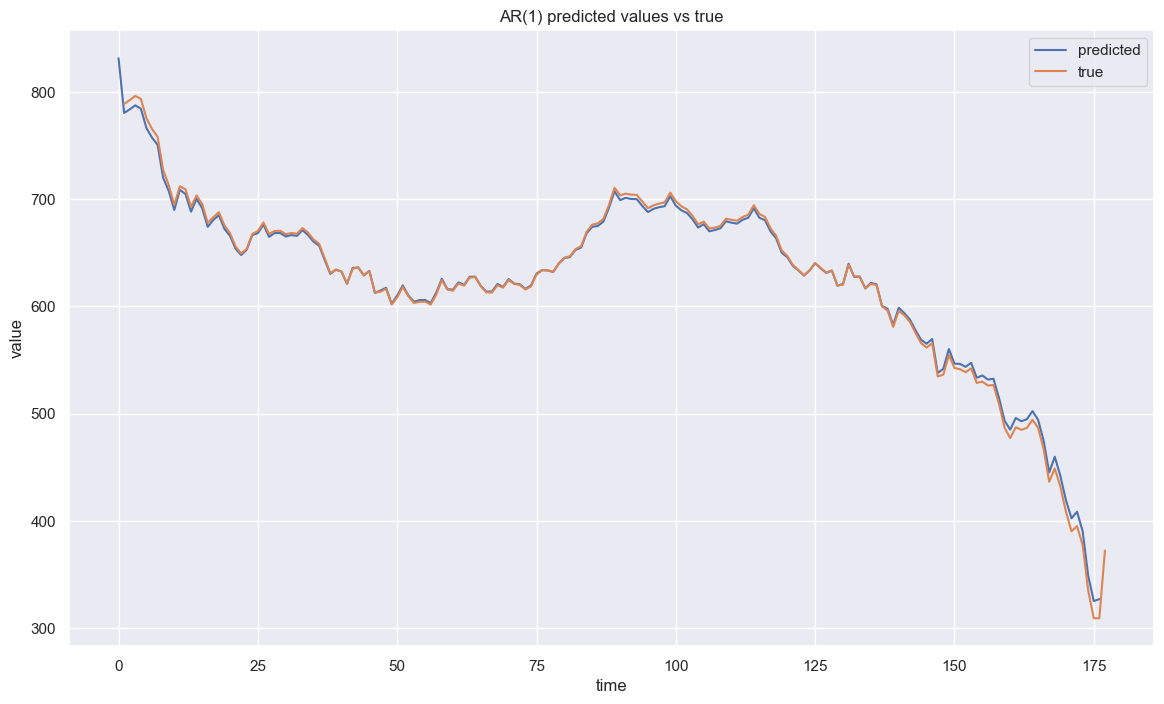

In [14]:
plt.plot(mls_rtsfn_1.predict(X_rtsfn_1)[1:], label='predicted')
plt.plot(RTSfn[1:], label='true')
plt.xlabel('time')
plt.ylabel('value')
plt.title('AR(1) predicted values vs true')
plt.legend()
plt.show()

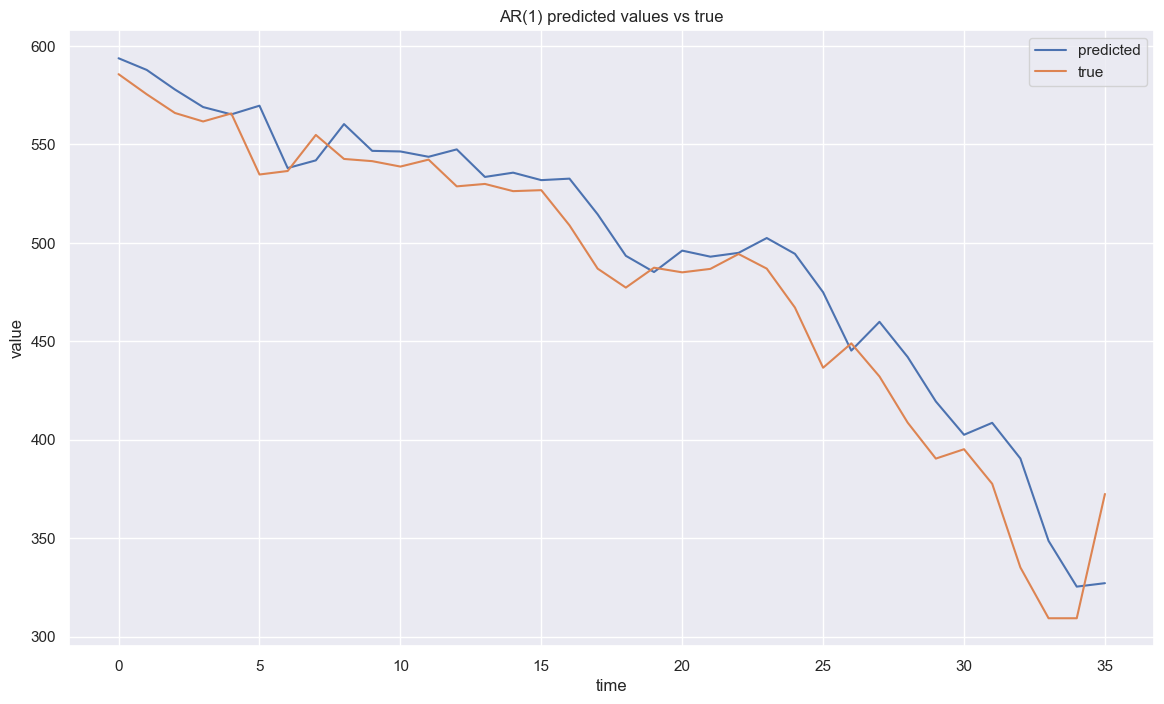

In [15]:
plt.plot(predicted, label='predicted')
plt.plot(y_test_rtsfn.values, label='true')
plt.xlabel('time')
plt.ylabel('value')
plt.title('AR(1) predicted values vs true')
plt.legend()
plt.show()

c:\Users\Kidma\anaconda3\envs\fullds\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


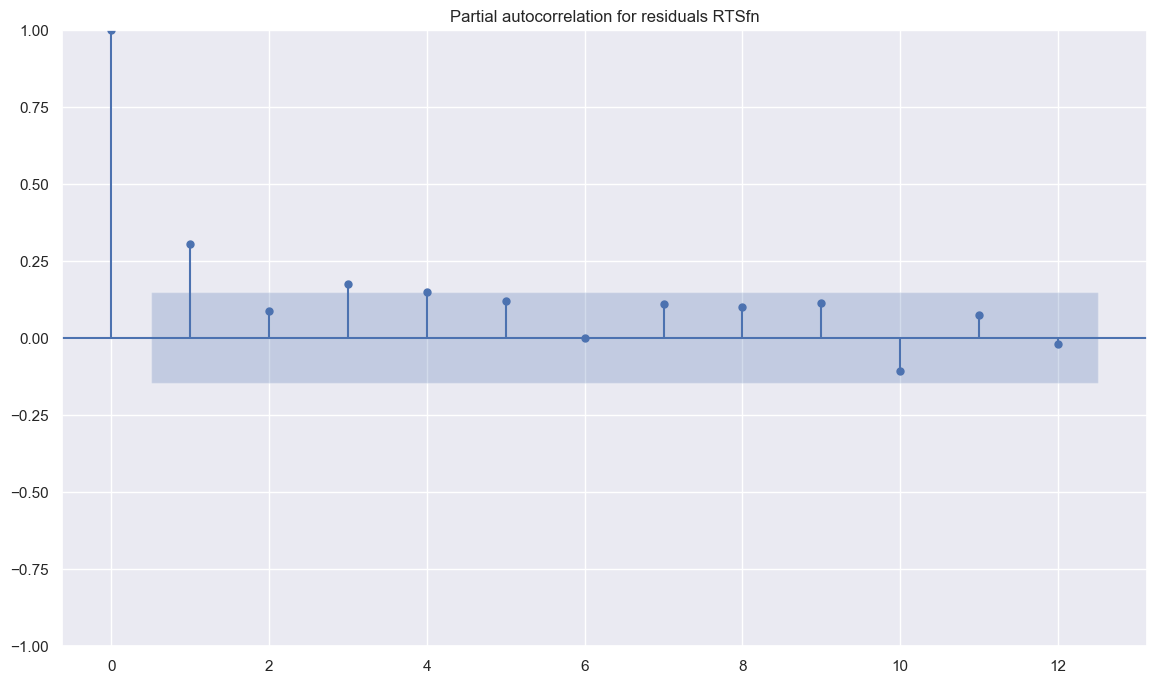

,autocorr,pacf
0,0.3030373603,0.3047690024
1,0.1687686924,0.0857932504
2,0.2273686104,0.1750270112
3,0.2441806452,0.1480437095
4,0.2292642584,0.1182410085
5,0.1362496900,-0.0022211243
6,0.1990507854,0.1093175219
7,0.2276473910,0.0984933631
8,0.2342895464,0.1128704091
9,0.0703558650,-0.1082759228


In [16]:
pacf_RTSfn = pd.DataFrame({'autocorr': acf(resid, nlags=12)[1:],
                            'pacf': pacf(resid, nlags=12)[1:]})
plot_pacf(resid, lags=12, title='Partial autocorrelation for residuals RTSfn')
plt.show()
pacf_RTSfn

q = 1, тому що більше ніякий лаг не має достатньо високе значення часткової автокореляції для того, щоб ми вважали кореляцію такого лагу статистично значимою

In [17]:
sma_5 = calculate_sma(resid, 5)
sma_10 = calculate_sma(resid, 10)
ema_5 = calculate_ema(resid, 5)
ema_10 = calculate_ema(resid, 10)

sma_5_1 = shift(sma_5, 1, cval=0)
sma_10_1 = shift(sma_10, 1, cval=0)
ema_5_1 = shift(ema_5, 1, cval=0)
ema_10_1 = shift(ema_10, 1, cval=0)

X_rtsfn = pd.DataFrame({'a_0': np.ones(len(y_k_1[2:])), 'y_k-1': y_k_1[2:],  'y_k-2': y_k_2[2:],
                           'sma_5': sma_5, 'sma_5_1': sma_5_1,
                           'sma_10': sma_10, 'sma_10_1': sma_10_1,
                           'ema_5': ema_5, 'ema_5_1': ema_5_1,
                           'ema_10': ema_10, 'ema_10_1': ema_10_1})

In [18]:
X_train_rtsfn_sma_5, X_test_rtsfn_sma_5, \
y_train_sma_5, y_test_sma_5, \
train_sma_5, test_sma_5 = train_test_split(X_rtsfn[4:], RTSfn.values.flatten()[6:] - sma_5[4:], sma_5[4:],
                                test_size=0.2, shuffle=False)

X_train_rtsfn_sma_10, X_test_rtsfn_sma_10, \
y_train_sma_10, y_test_sma_10, \
train_sma_10, test_sma_10 = train_test_split(X_rtsfn[9:], RTSfn.values.flatten()[11:] - sma_10[9:], sma_10[9:],
                                test_size=0.2, shuffle=False)

X_train_rtsfn_ema_5, X_test_rtsfn_ema_5, \
y_train_ema_5, y_test_ema_5, \
train_ema_5, test_ema_5 = train_test_split(X_rtsfn[4:], RTSfn.values.flatten()[6:] - ema_5[4:], ema_5[4:],
                                test_size=0.2, shuffle=False)

X_train_rtsfn_ema_10, X_test_rtsfn_ema_10, \
y_train_ema_10, y_test_ema_10, \
train_ema_10, test_ema_10 = train_test_split(X_rtsfn[9:], RTSfn.values.flatten()[11:] - ema_10[9:], ema_10[9:],
                                test_size=0.2, shuffle=False)

In [19]:
# sma 5
mls = MLS()

mls.fit(X_train_rtsfn_sma_5[['a_0', 'y_k-1', 'y_k-2', 'sma_5_1']], y_train_sma_5)

predicted = mls.predict(X_test_rtsfn_sma_5[['a_0', 'y_k-1', 'y_k-2', 'sma_5_1']]) + test_sma_5

results = add_results(results, y_test_sma_5 + test_sma_5, predicted)

print(f'sma 5 - {mls.coefs} \n')

# sma 10
mls = MLS()

mls.fit(X_train_rtsfn_sma_10[['a_0', 'y_k-1', 'y_k-2', 'sma_10_1']], y_train_sma_10)

predicted = mls.predict(X_test_rtsfn_sma_10[['a_0', 'y_k-1', 'y_k-2', 'sma_10_1']]) + test_sma_10

results = add_results(results, y_test_sma_10 + test_sma_10, predicted)

print(f'sma 10 - {mls.coefs} \n')

# ema 5
mls = MLS()

mls.fit(X_train_rtsfn_ema_5[['a_0', 'y_k-1', 'y_k-2', 'ema_5_1']], y_train_ema_5)

predicted = mls.predict(X_test_rtsfn_ema_5[['a_0', 'y_k-1', 'y_k-2', 'ema_5_1']]) + test_ema_5

results = add_results(results, y_test_ema_5 + test_ema_5, predicted)

print(f'ema 5 - {mls.coefs} \n')

# ema 10
mls = MLS()

mls.fit(X_train_rtsfn_ema_10[['a_0', 'y_k-1', 'y_k-2', 'ema_10_1']], y_train_ema_10)

predicted = mls.predict(X_test_rtsfn_ema_10[['a_0', 'y_k-1', 'y_k-2', 'ema_10_1']]) + test_ema_10

results = add_results(results, y_test_ema_10 + test_ema_10, predicted)

print(f'ema 10 - {mls.coefs} \n')
results

sma 5 - [array([46.75243901,  0.8695176 ,  0.05680174, -0.42243247])] 

sma 10 - [array([29.99472189,  0.90557679,  0.04675004, -0.44128864])] 

ema 5 - [array([46.86345485,  0.88060449,  0.04551326, -0.29787983])] 

ema 10 - [array([40.24798811,  0.8482431 ,  0.08804797, -0.17634952])] 



,S,R^2,IKA,DW,MSE,RMSE
0,17547.2555927628,0.8961901446,357.8155022467,0.8505980982,487.4237664656,22.0776757487
1,10728.2980170674,0.9386896396,330.8224071381,0.9336393232,306.5228004876,17.5077925647
2,10185.3754474871,0.9690159923,319.7760784861,1.1573552599,299.5698661026,17.3080867256
3,7268.1118360446,0.9391649709,317.1938135899,0.9417097250,207.6603381727,14.4104246354
4,8939.6070534243,0.9695545582,315.3403950572,1.1547856339,262.9296192184,16.2151046626


## по вихідному сигналу

p - те ж саме (2)

c:\Users\Kidma\anaconda3\envs\fullds\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


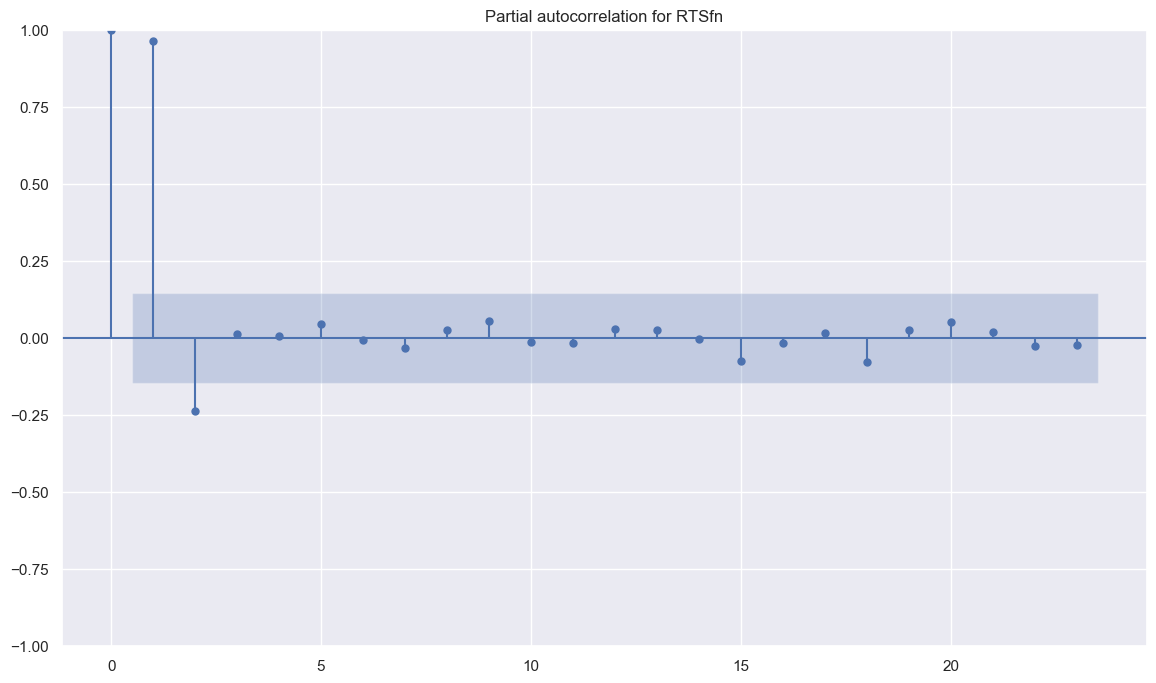

,autocorr,pacf
0,0.9596689675,0.9650908261
1,0.9048214684,-0.2375633218
2,0.8498453104,0.0111279798
3,0.7979560892,0.0063390725
4,0.7521555424,0.0455353131
5,0.7099451946,-0.0077856942
6,0.6681882605,-0.0341880314
7,0.6294990882,0.0268335498
8,0.5966814828,0.0540140302
9,0.5665437560,-0.0122048385


In [20]:
pacf_RTSfn = pd.DataFrame({'autocorr': acf(RTSfn['RTSfn'], nlags=12)[1:],
                            'pacf': pacf(RTSfn, nlags=12)[1:]})
plot_pacf(RTSfn, title='Partial autocorrelation for RTSfn')

plt.show()
pacf_RTSfn

## q
### sma 5

c:\Users\Kidma\anaconda3\envs\fullds\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


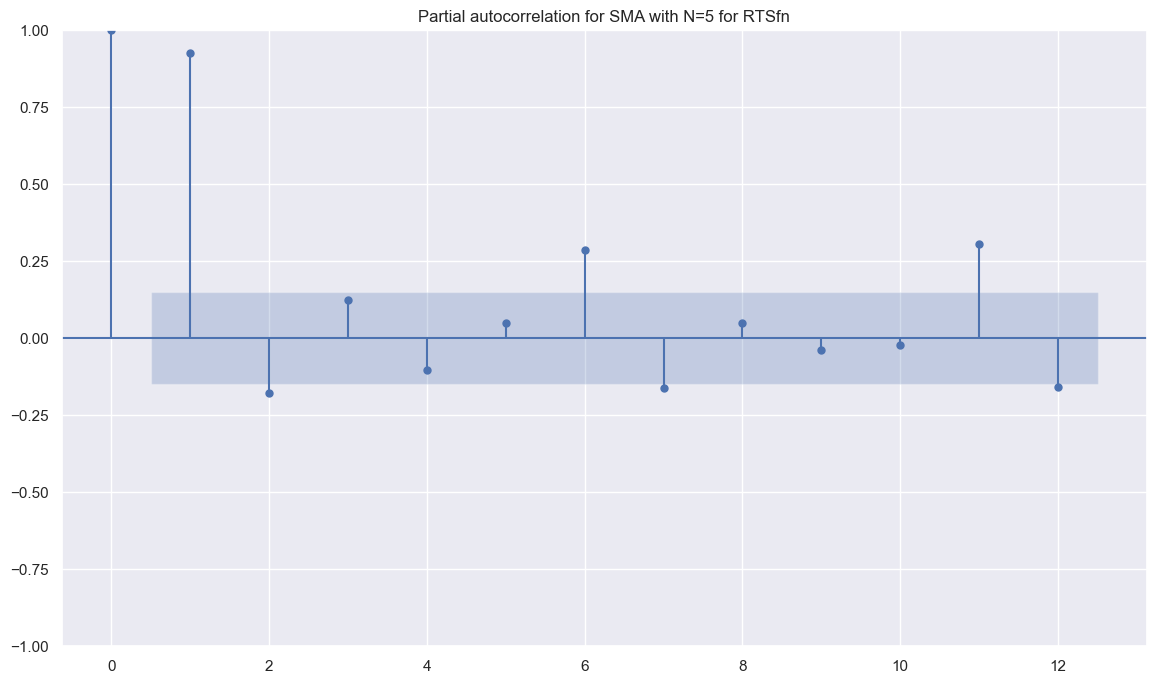

,autocorr,pacf
0,0.9182948439,0.9236649892
1,0.8171189414,-0.1799534806
2,0.7391239110,0.1226071731
3,0.6601713767,-0.1040757439
4,0.5895388485,0.0472811984
5,0.5685855551,0.2866595278
6,0.5417353951,-0.1645694519
7,0.5053464094,0.0469125936
8,0.4728556328,-0.0400107791
9,0.4384142802,-0.0243729496


In [21]:
pacf_RTSfn = pd.DataFrame({'autocorr': acf(sma_5[4:], nlags=12)[1:],
                            'pacf': pacf(sma_5[4:], nlags=12)[1:]})
plot_pacf(sma_5[4:], title='Partial autocorrelation for SMA with N=5 for RTSfn', lags=12)

plt.show()
pacf_RTSfn

Для SMA з вікном 5 ми отримали значення q - 6

### sma 10

c:\Users\Kidma\anaconda3\envs\fullds\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


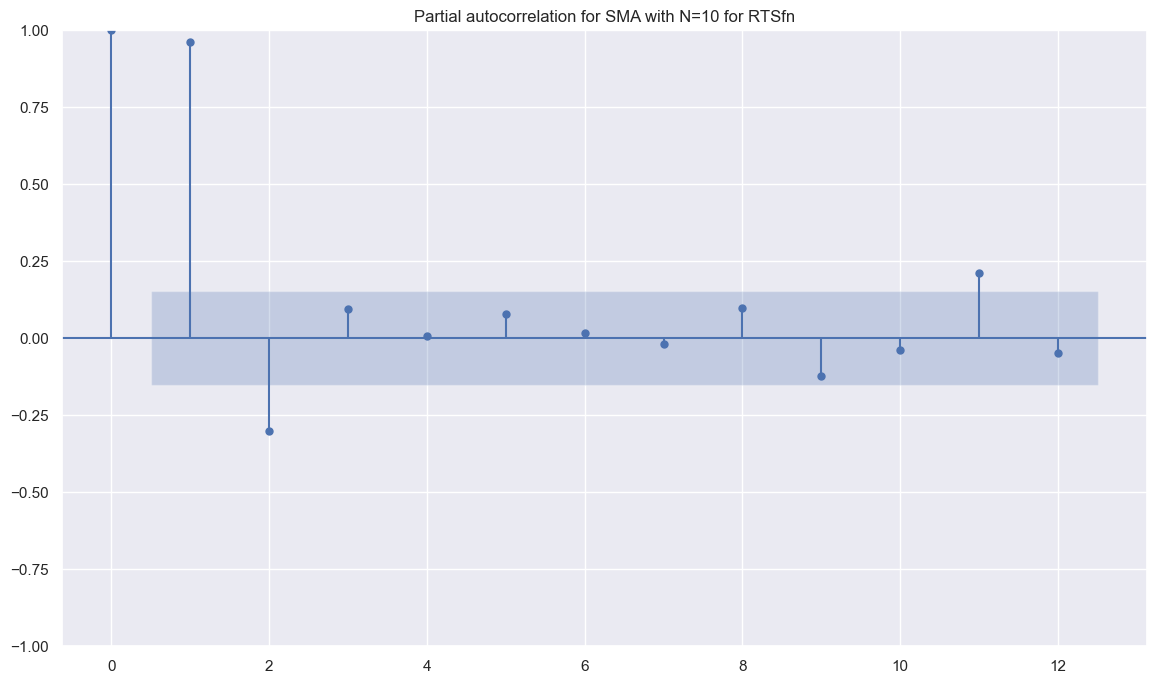

,autocorr,pacf
0,0.9530825823,0.9588240437
1,0.8842811519,-0.3018212985
2,0.8195110323,0.0919566720
3,0.7618474419,0.0059328581
4,0.7146968945,0.0771714738
5,0.6753867946,0.0172212402
6,0.6382757484,-0.0187655039
7,0.6086681258,0.0955373737
8,0.5752863564,-0.1248742311
9,0.5355710057,-0.0387951711


In [22]:
pacf_RTSfn = pd.DataFrame({'autocorr': acf(sma_10[9:], nlags=12)[1:],
                            'pacf': pacf(sma_10[9:], nlags=12)[1:]})
plot_pacf(sma_10[9:], title='Partial autocorrelation for SMA with N=10 for RTSfn', lags=12)

plt.show()

pacf_RTSfn

Для SMA з вікном 10 ми отримали значення q - 2

### ema 5

c:\Users\Kidma\anaconda3\envs\fullds\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


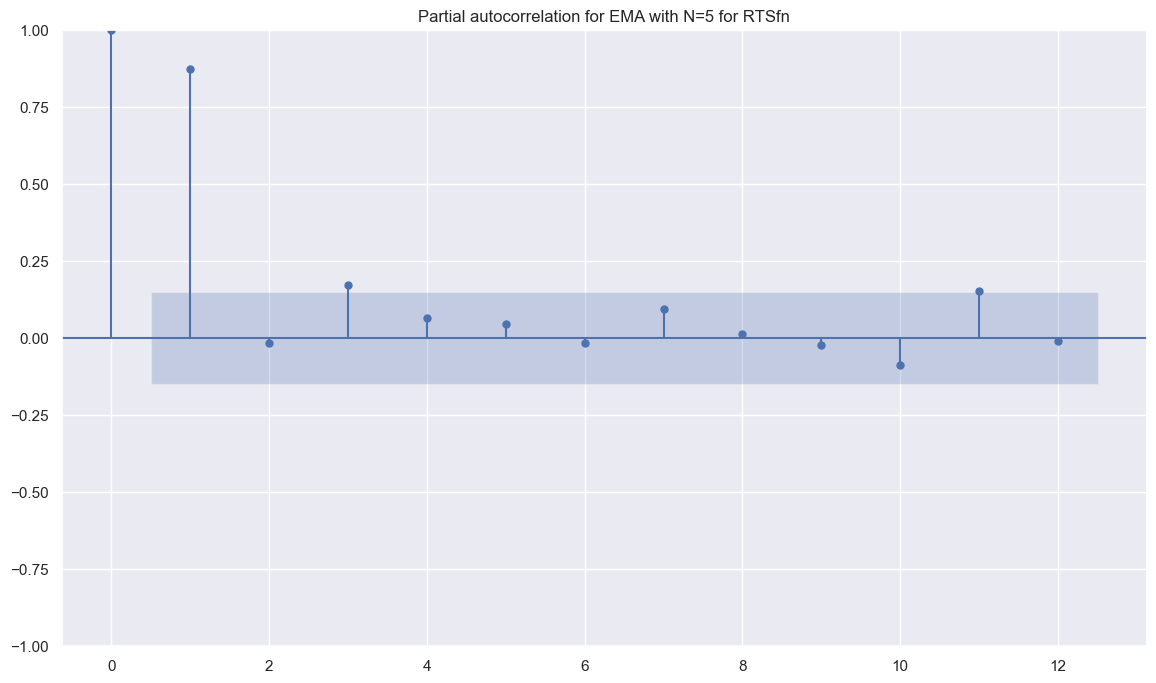

,autocorr,pacf
0,0.8672423430,0.8723139356
1,0.7479217481,-0.0176132641
2,0.6851736000,0.1714524012
3,0.6416115391,0.0634075928
4,0.6019092945,0.0457600985
5,0.5541785027,-0.0181297590
6,0.5282783354,0.0937244979
7,0.5062003969,0.0128670924
8,0.4716103268,-0.0243365558
9,0.4183042545,-0.0871626690


In [23]:
pacf_RTSfn = pd.DataFrame({'autocorr': acf(ema_5[4:], nlags=12)[1:],
                            'pacf': pacf(ema_5[4:], nlags=12)[1:]})
plot_pacf(ema_5[4:], title='Partial autocorrelation for EMA with N=5 for RTSfn', lags=12)
plt.show()

pacf_RTSfn

Для EMA з вікном 5 ми отримали значення q - 2

### ema 10

c:\Users\Kidma\anaconda3\envs\fullds\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


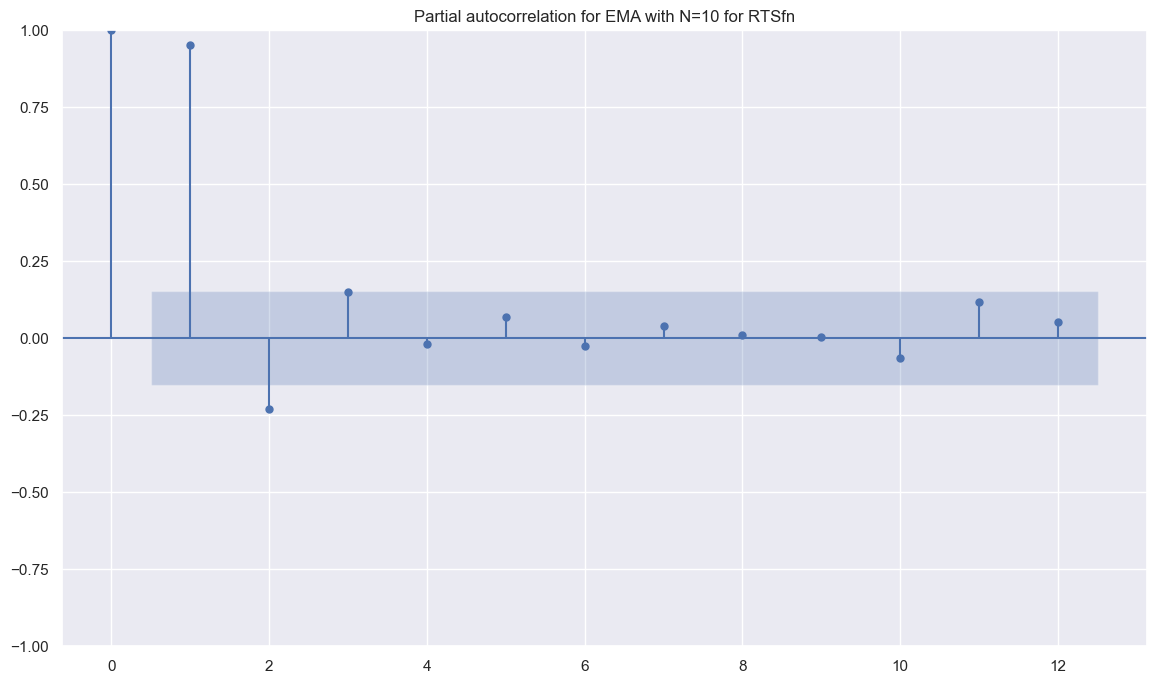

,autocorr,pacf
0,0.9435032004,0.9491869546
1,0.8674530880,-0.2321006311
2,0.8056445652,0.1484503733
3,0.7521986044,-0.0190473557
4,0.7074965739,0.0667112753
5,0.6656267425,-0.0257402118
6,0.6275768141,0.0377459997
7,0.5937993410,0.0093848950
8,0.5619200033,0.0025826375
9,0.5257691022,-0.0655549774


In [24]:
pacf_RTSfn = pd.DataFrame({'autocorr': acf(ema_10[9:], nlags=12)[1:],
                            'pacf': pacf(ema_10[9:], nlags=12)[1:]})
plot_pacf(ema_10[9:], title='Partial autocorrelation for EMA with N=10 for RTSfn', lags=12)
plt.show()

pacf_RTSfn

Для EMA з вікном 10 ми отримали значення q - 2

In [25]:
X_rtsfn = pd.DataFrame({'a_0': np.ones(len(y_k_1[2:])), 'y_k-1': y_k_1[2:],  'y_k-2': y_k_2[2:],
                           'sma_5': sma_5, 'sma_5_1': sma_5_1,
                           'sma_5_2': shift(sma_5, 2, cval=0), 'sma_5_3': shift(sma_5, 3, cval=0),
                           'sma_5_4': shift(sma_5, 4, cval=0), 'sma_5_5': shift(sma_5, 5, cval=0),
                           'sma_5_6': shift(sma_5, 6, cval=0),
                           'sma_10': sma_10, 'sma_10_1': sma_10_1, 'sma_10_2': shift(sma_10, 2, cval=0),
                           'ema_5': ema_5, 'ema_5_1': ema_5_1, 'ema_5_2': shift(ema_5, 2, cval=0), 
                           'ema_10': ema_10, 'ema_10_1': ema_10_1, 'ema_10_2': shift(ema_10, 2, cval=0)})

## creating second arma models for precomputed ma values

Відняти с коефіцієнами

In [26]:
sma_5_MA_part = sma_5[10:] + 0.33*X_rtsfn['sma_5_1'][10:] + 0.235*X_rtsfn['sma_5_2'][10:] + 0.168*X_rtsfn['sma_5_3'][10:] + 0.12*X_rtsfn['sma_5_4'][10:] + 0.086*X_rtsfn['sma_5_5'][10:] + 0.061*X_rtsfn['sma_5_6'][10:]

sma_10_MA_part = sma_10[11:] + 0.75*X_rtsfn['sma_10_1'][11:] + 0.25*X_rtsfn['sma_10_2'][11:]

ema_5_MA_part = ema_5[10:] + 0.75*X_rtsfn['ema_5_1'][10:] + 0.25*X_rtsfn['ema_5_2'][10:]

ema_10_MA_part = ema_10[11:] + 0.75*X_rtsfn['ema_10_1'][11:] + 0.25*X_rtsfn['ema_10_2'][11:] 

# + 0.168*X_rtsfn['ema_5_3'][10:] + 0.12*X_rtsfn['ema_5_4'][10:] + 0.086*X_rtsfn['ema_5_5'][10:] + 0.061*X_rtsfn['ema_5_6'][10:]

In [27]:
X_train_rtsfn_sma_5, X_test_rtsfn_sma_5, \
y_train_sma_5, y_test_sma_5, \
train_sma_5_MA_part, test_sma_5_MA_part = train_test_split(X_rtsfn[10:],
                                           np.subtract(RTSfn.values.flatten()[12:], sma_5_MA_part),
                                           sma_5_MA_part,
                                           test_size=0.2, shuffle=False)

X_train_rtsfn_sma_10, X_test_rtsfn_sma_10, \
y_train_sma_10, y_test_sma_10, \
train_sma_10_MA_part, test_sma_10_MA_part = train_test_split(X_rtsfn[11:],
                                             np.subtract(RTSfn.values.flatten()[13:], sma_10_MA_part),
                                             sma_10_MA_part,
                                             test_size=0.2, shuffle=False)

X_train_rtsfn_ema_5, X_test_rtsfn_ema_5, \
y_train_ema_5, y_test_ema_5, \
train_ema_5_MA_part, test_ema_5_MA_part = train_test_split(X_rtsfn[10:],
                                           np.subtract(RTSfn.values.flatten()[12:], ema_5_MA_part),
                                           ema_5_MA_part,
                                           test_size=0.2, shuffle=False)

X_train_rtsfn_ema_10, X_test_rtsfn_ema_10, \
y_train_ema_10, y_test_ema_10, \
train_ema_10_MA_part, test_ema_10_MA_part = train_test_split(X_rtsfn[11:],
                                             np.subtract(RTSfn.values.flatten()[13:], ema_10_MA_part),
                                             ema_10_MA_part,
                                             test_size=0.2, shuffle=False)

In [28]:
# sma 5
mls = MLS()

mls.fit(X_train_rtsfn_sma_5[['a_0', 'y_k-1', 'y_k-2']], y_train_sma_5)

predicted = mls.predict(X_test_rtsfn_sma_5[['a_0', 'y_k-1', 'y_k-2']]) + test_sma_5_MA_part

results = add_results(results, y_test_sma_5 + test_sma_5_MA_part, predicted)

print(f'sma 5 - {mls.coefs} \n')

# sma 10
mls = MLS()

mls.fit(X_train_rtsfn_sma_10[['a_0', 'y_k-1', 'y_k-2']], y_train_sma_10)

predicted = mls.predict(X_test_rtsfn_sma_10[['a_0', 'y_k-1', 'y_k-2']]) + test_sma_10_MA_part

results = add_results(results, y_test_sma_10 +test_sma_10_MA_part, predicted)

print(f'sma 10 - {mls.coefs} \n')

# ema 5
mls = MLS()

mls.fit(X_train_rtsfn_ema_5[['a_0', 'y_k-1', 'y_k-2']], y_train_ema_5)

predicted = mls.predict(X_test_rtsfn_ema_5[['a_0', 'y_k-1', 'y_k-2']]) + test_ema_5_MA_part

results = add_results(results, y_test_ema_5 + test_ema_5_MA_part, predicted)

print(f'ema 5 - {mls.coefs} \n')

# ema 10
mls = MLS()

mls.fit(X_train_rtsfn_ema_10[['a_0', 'y_k-1', 'y_k-2']], y_train_ema_10)

predicted = mls.predict(X_test_rtsfn_ema_10[['a_0', 'y_k-1', 'y_k-2']]) + test_ema_10_MA_part

results = add_results(results, y_test_ema_10 + test_ema_10_MA_part, predicted)

print(f'ema 10 - {mls.coefs} \n')
results

sma 5 - [array([96.30129156,  0.70387451,  0.1457636 ])] 

sma 10 - [array([93.89366976,  0.76896371,  0.08408256])] 

ema 5 - [array([92.10023363,  0.52671269,  0.32905191])] 

ema 10 - [array([94.99481582,  0.6831301 ,  0.16784959])] 



,S,R^2,IKA,DW,MSE,RMSE
0,17547.2555927628,0.8961901446,357.8155022467,0.8505980982,487.4237664656,22.0776757487
1,10728.2980170674,0.9386896396,330.8224071381,0.9336393232,306.5228004876,17.5077925647
2,10185.3754474871,0.9690159923,319.7760784861,1.1573552599,299.5698661026,17.3080867256
3,7268.1118360446,0.9391649709,317.1938135899,0.9417097250,207.6603381727,14.4104246354
4,8939.6070534243,0.9695545582,315.3403950572,1.1547856339,262.9296192184,16.2151046626
5,9482.5156975143,1.0240087500,317.3449675854,1.1021354683,278.8975205151,16.7002251636
6,10767.3062554331,0.9871040863,312.3808975692,1.1344052002,326.2820077404,18.0632778792
7,7189.2473795646,1.0181119417,307.9316201541,1.1542894939,211.4484523401,14.5412672192
8,9601.4051615226,0.9828000933,308.5989363453,1.1347467952,290.9516715613,17.0573055188


Ми отримали R^2 більше за 1, це пов'язано з тим як ми рахуємо цю метрику, ми отримуємо відношення дисперсії нашого передбачуваного значення до справжнього, тому значення більше одиниці показує нам те, що просто у нашому передбаченні дисперсія більше 

## Обчислення коефіцієнтів

In [29]:
X_train_rtsfn_sma_5, X_test_rtsfn_sma_5, \
y_train_sma_5, y_test_sma_5, \
train_sma_5, test_sma_5 = train_test_split(X_rtsfn[4:], RTSfn.values.flatten()[6:] - sma_5[4:], sma_5[4:],
                                test_size=0.2, shuffle=False)

X_train_rtsfn_sma_10, X_test_rtsfn_sma_10, \
y_train_sma_10, y_test_sma_10, \
train_sma_10, test_sma_10 = train_test_split(X_rtsfn[9:], RTSfn.values.flatten()[11:] - sma_10[9:], sma_10[9:],
                                test_size=0.2, shuffle=False)

X_train_rtsfn_ema_5, X_test_rtsfn_ema_5, \
y_train_ema_5, y_test_ema_5, \
train_ema_5, test_ema_5 = train_test_split(X_rtsfn[4:], RTSfn.values.flatten()[6:] - ema_5[4:], ema_5[4:],
                                test_size=0.2, shuffle=False)

X_train_rtsfn_ema_10, X_test_rtsfn_ema_10, \
y_train_ema_10, y_test_ema_10, \
train_ema_10, test_ema_10 = train_test_split(X_rtsfn[9:], RTSfn.values.flatten()[11:] - ema_10[9:], ema_10[9:],
                                test_size=0.2, shuffle=False)

In [30]:
# sma 5
mls = MLS()

mls.fit(X_train_rtsfn_sma_5[['a_0', 'y_k-1', 'y_k-2', 'sma_5_1', 'sma_5_2',
                             'sma_5_3', 'sma_5_4', 'sma_5_5', 'sma_5_6']], y_train_sma_5)

predicted = mls.predict(X_test_rtsfn_sma_5[['a_0', 'y_k-1', 'y_k-2', 'sma_5_1', 'sma_5_2',
                             'sma_5_3', 'sma_5_4', 'sma_5_5', 'sma_5_6']]) + test_sma_5

results = add_results(results, y_test_sma_5 + test_sma_5, predicted)

print(f'sma 5 - {mls.coefs} \n')

# sma 10
mls = MLS()

mls.fit(X_train_rtsfn_sma_10[['a_0', 'y_k-1', 'y_k-2', 'sma_10_1', 'sma_10_2']], y_train_sma_10)

predicted = mls.predict(X_test_rtsfn_sma_10[['a_0', 'y_k-1', 'y_k-2', 'sma_10_1', 'sma_10_2']]) + test_sma_10

results = add_results(results, y_test_sma_10 + test_sma_10, predicted)

print(f'sma 10 - {mls.coefs} \n')

# ema 5
mls = MLS()

mls.fit(X_train_rtsfn_ema_5[['a_0', 'y_k-1', 'y_k-2', 'ema_5_1', 'ema_5_2']], y_train_ema_5)

# 'ema_5_3', 'ema_5_4', 'ema_5_5', 'ema_5_6'

predicted = mls.predict(X_test_rtsfn_ema_5[['a_0', 'y_k-1', 'y_k-2', 'ema_5_1', 'ema_5_2']]) + test_ema_5

results = add_results(results, y_test_ema_5 + test_ema_5, predicted)

print(f'ema 5 - {mls.coefs} \n')

# ema 10
mls = MLS()

mls.fit(X_train_rtsfn_ema_10[['a_0', 'y_k-1', 'y_k-2', 'ema_10_1', 'ema_10_2']], y_train_ema_10)

predicted = mls.predict(X_test_rtsfn_ema_10[['a_0', 'y_k-1', 'y_k-2', 'ema_10_1', 'ema_10_2']]) + test_ema_10

results = add_results(results, y_test_ema_10 + test_ema_10, predicted)

print(f'ema 10 - {mls.coefs} \n')
results

sma 5 - [array([55.47395893,  0.78763012,  0.1250966 ,  0.09923155, -1.00550132,
        0.76172461, -0.78188393,  1.21732444, -0.40211867])] 

sma 10 - [array([30.05317766,  0.90799187,  0.04424673, -0.46822175,  0.02797582])] 

ema 5 - [array([52.7843688 ,  0.75345448,  0.16333502,  0.08516291, -0.23591401])] 

ema 10 - [array([59.4484908 ,  0.26983018,  0.63600376,  3.22275771, -2.81266404])] 



,S,R^2,IKA,DW,MSE,RMSE
0,17547.2555927628,0.8961901446,357.8155022467,0.8505980982,487.4237664656,22.0776757487
1,10728.2980170674,0.9386896396,330.8224071381,0.9336393232,306.5228004876,17.5077925647
2,10185.3754474871,0.9690159923,319.7760784861,1.1573552599,299.5698661026,17.3080867256
3,7268.1118360446,0.9391649709,317.1938135899,0.9417097250,207.6603381727,14.4104246354
4,8939.6070534243,0.9695545582,315.3403950572,1.1547856339,262.9296192184,16.2151046626
5,9482.5156975143,1.0240087500,317.3449675854,1.1021354683,278.8975205151,16.7002251636
6,10767.3062554331,0.9871040863,312.3808975692,1.1344052002,326.2820077404,18.0632778792
7,7189.2473795646,1.0181119417,307.9316201541,1.1542894939,211.4484523401,14.5412672192
8,9601.4051615226,0.9828000933,308.5989363453,1.1347467952,290.9516715613,17.0573055188
9,9515.3567209855,0.9392273770,326.6231794293,1.0308641998,271.8673348853,16.4884000099


In [31]:
idx = ['AR(2)', 
       'ARMA(2, 1)_resid_sma5', 'ARMA(2, 1)_resid_sma10', 'ARMA(2, 1)_resid_ema5', 'ARMA(2, 1)_resid_ema10',
       'ARMA(2, 6)_precomp_sma5', 'ARMA(2, 3)_precomp_sma10', 'ARMA(2, 3)_precomp_ema5', 'ARMA(2, 3)_precomp_ema10',
       'ARMA(2, 2)_computing_sma5', 'ARMA(2, 6)_computing_sma10', 'ARMA(2, 6)_computing_ema5', 'ARMA(2, 6)_computing_ema10']

results = results.set_index(pd.Index(idx))

results

,S,R^2,IKA,DW,MSE,RMSE
AR(2),17547.2555927628,0.8961901446,357.8155022467,0.8505980982,487.4237664656,22.0776757487
"ARMA(2, 1)_resid_sma5",10728.2980170674,0.9386896396,330.8224071381,0.9336393232,306.5228004876,17.5077925647
"ARMA(2, 1)_resid_sma10",10185.3754474871,0.9690159923,319.7760784861,1.1573552599,299.5698661026,17.3080867256
"ARMA(2, 1)_resid_ema5",7268.1118360446,0.9391649709,317.1938135899,0.9417097250,207.6603381727,14.4104246354
"ARMA(2, 1)_resid_ema10",8939.6070534243,0.9695545582,315.3403950572,1.1547856339,262.9296192184,16.2151046626
"ARMA(2, 6)_precomp_sma5",9482.5156975143,1.0240087500,317.3449675854,1.1021354683,278.8975205151,16.7002251636
"ARMA(2, 3)_precomp_sma10",10767.3062554331,0.9871040863,312.3808975692,1.1344052002,326.2820077404,18.0632778792
"ARMA(2, 3)_precomp_ema5",7189.2473795646,1.0181119417,307.9316201541,1.1542894939,211.4484523401,14.5412672192
"ARMA(2, 3)_precomp_ema10",9601.4051615226,0.9828000933,308.5989363453,1.1347467952,290.9516715613,17.0573055188
"ARMA(2, 2)_computing_sma5",9515.3567209855,0.9392273770,326.6231794293,1.0308641998,271.8673348853,16.4884000099


## Найкраща модель (судячи по сумі квардатів похибок)

In [32]:
best_model = MLS()

best_model.fit(X_train_rtsfn_ema_10[['a_0', 'y_k-1', 'y_k-2', 'ema_10_1', 'ema_10_2']], y_train_ema_10)

predicted = best_model.predict(X_test_rtsfn_ema_10[['a_0', 'y_k-1', 'y_k-2', 'ema_10_1', 'ema_10_2']]) + test_ema_10

best_model.weights()

array([59.4484908 ,  0.26983018,  0.63600376,  3.22275771, -2.81266404])

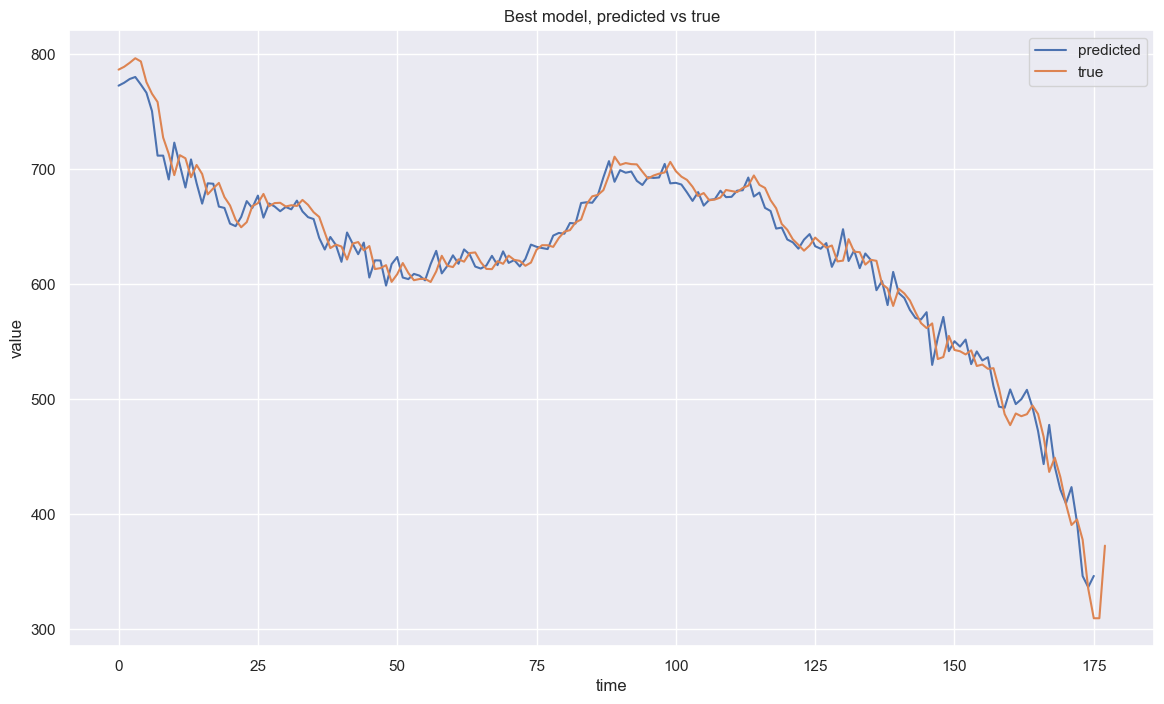

In [33]:
plt.plot(best_model.predict(X_rtsfn[['a_0', 'y_k-1', 'y_k-2', 'ema_5_1', 'ema_5_2']]), label='predicted')
plt.plot(RTSfn, label='true')
plt.xlabel('time')
plt.ylabel('value')
plt.title('Best model, predicted vs true')
plt.legend()
plt.show()

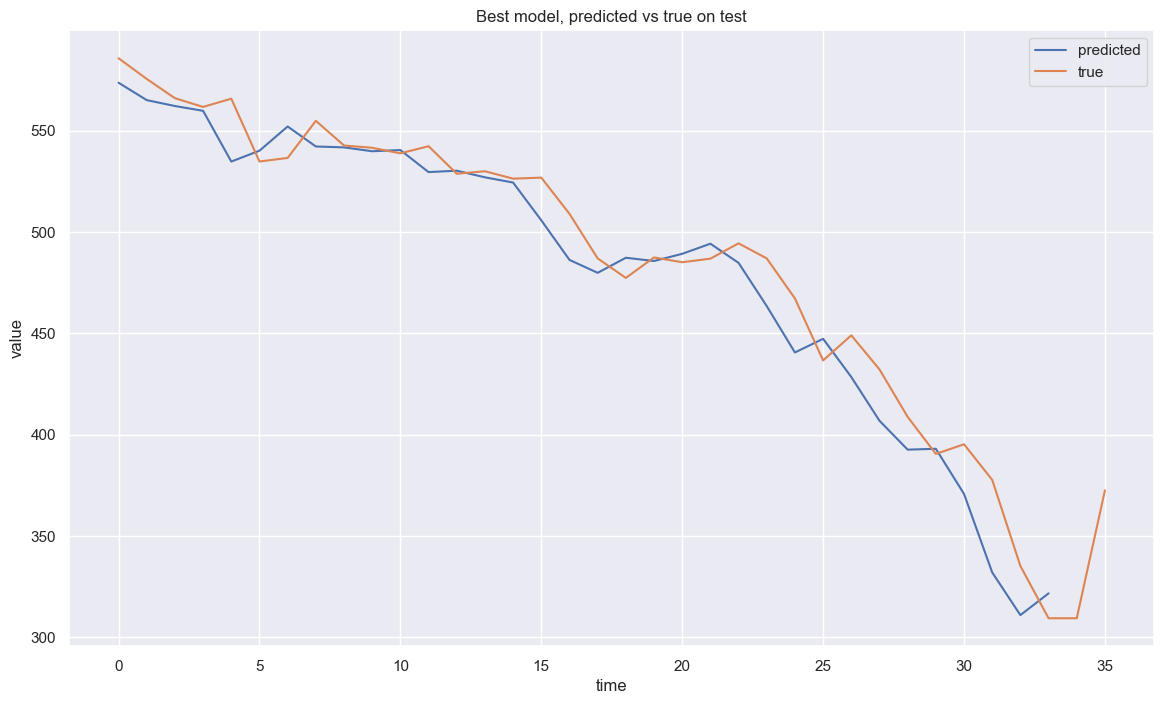

In [34]:
plt.plot(predicted, label='predicted')
plt.plot(y_test_rtsfn.values, label='true')
plt.xlabel('time')
plt.ylabel('value')
plt.title('Best model, predicted vs true on test')
plt.legend()
plt.show()

## Best model:

$$ y(k) = 59.448 +0.27 \cdot y(k-1)  +0.6360 \cdot y(k-2) + v(k) +3.222 \cdot v(k-1)  + -2.813\cdot v(k-2) $$

In [35]:
results.loc['ARMA(2, 6)_computing_ema10'].T

S      8580.7697975569
R^2       0.9701817540
IKA     313.9474828874
DW        1.1894940478
MSE     252.3755822811
RMSE     15.8863331918
Name: ARMA(2, 6)_computing_ema10, dtype: float64

# rts2000

,rts2000
count,250.0000000000
mean,194.6021600000
std,24.5332520707
min,132.0700000000
25%,180.1250000000
50%,192.5000000000
75%,213.2350000000
max,245.4900000000
jarque_bera,2.1245395199
p-value,0.3456703306


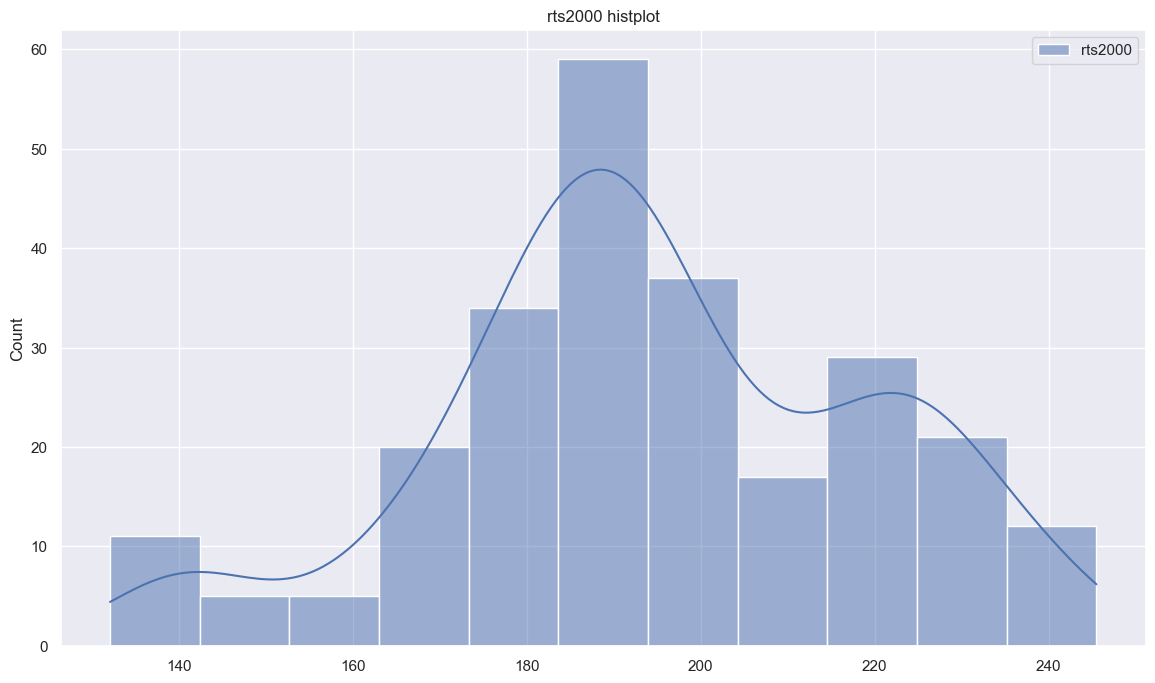

In [36]:
sns.histplot(rts2000, kde=True).set(title='rts2000 histplot')

rts2000_stats = rts2000.describe()

stats_values = jarque_bera(rts2000_stats)
index_values = ['jarque_bera', 'p-value', 'skew', 'kurtosis']
for idx, value in zip(index_values, stats_values):
    rts2000_stats.loc[idx, 'rts2000'] = value

rts2000_stats

## Finding p for AR

c:\Users\Kidma\anaconda3\envs\fullds\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


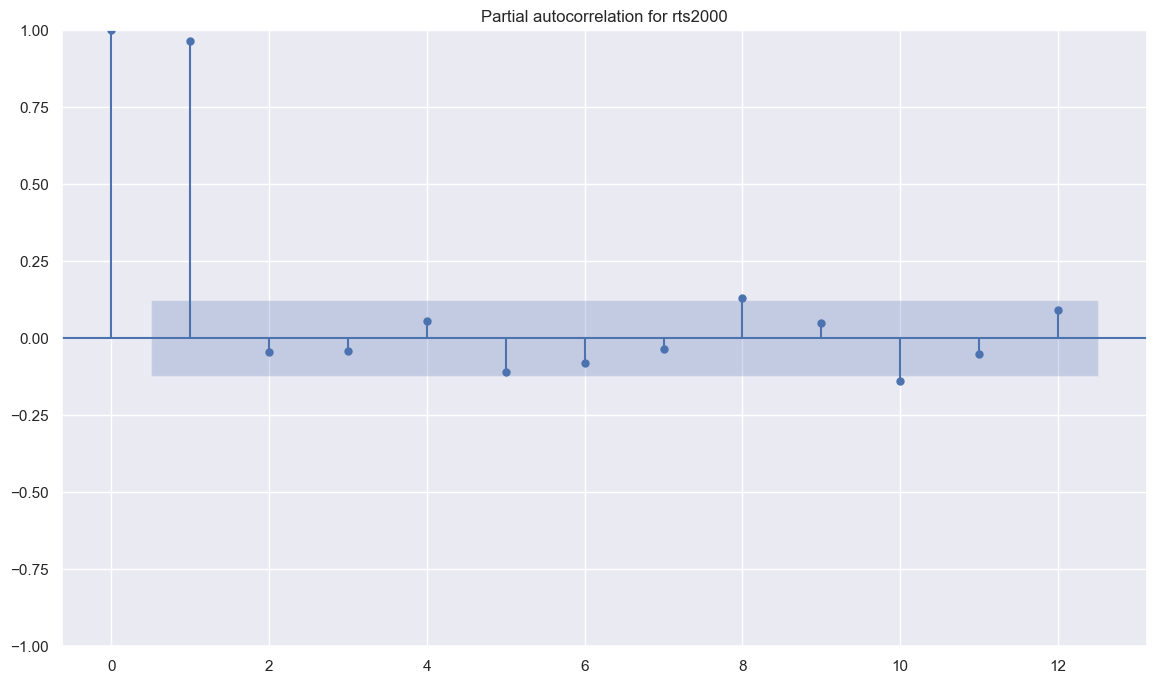

,autocorr,pacf
0,0.9600953134,0.9639511178
1,0.9186402997,-0.0445359695
2,0.8758540324,-0.0424435257
3,0.8385907641,0.0551586092
4,0.7954230446,-0.1115265231
5,0.7484247082,-0.0819898886
6,0.7001318521,-0.0368983329
7,0.6633647422,0.1298569776
8,0.6320543840,0.0491666131
9,0.5934641795,-0.1395431815


In [37]:
pacf_rts2000 = pd.DataFrame({'autocorr': acf(rts2000, nlags=12)[1:],
                            'pacf': pacf(rts2000, nlags=12)[1:]})
plot_pacf(rts2000, title='Partial autocorrelation for rts2000', lags=12)
plt.show()
pacf_rts2000

p = 1

## Створення АРКС по залишкам АР(р) моделі

### q for MA

In [38]:
y_k_1 = shift(rts2000['rts2000'], 1, cval=0)

X_rts2000_1 = pd.DataFrame({'a_0': np.ones(len(y_k_1)), 'y_k-1': y_k_1})

X_rts2000_1

,a_0,y_k-1
0,1.0000000000,0.0000000000
1,1.0000000000,179.0100000000
2,1.0000000000,185.5200000000
3,1.0000000000,192.2500000000
4,1.0000000000,182.3300000000
...,...,...
245,1.0000000000,138.1700000000
246,1.0000000000,140.7100000000
247,1.0000000000,141.1700000000
248,1.0000000000,139.8200000000


In [39]:
X_train_rts2000, X_test_rts2000, y_train_rts2000, y_test_rts2000 = train_test_split(X_rts2000_1[1:],
                                                                            rts2000[1:], test_size=0.2,
                                                                            random_state=42, shuffle=False)

In [40]:
mls_rts2000_1 = MLS()

mls_rts2000_1.fit(X_train_rts2000, y_train_rts2000)

predicted = mls_rts2000_1.predict(X_test_rts2000)

resid = pd.Series(rts2000.values.flatten()[1:] - mls_rts2000_1.predict(X_rts2000_1[1:]))

results_2 = add_results(results_2, y_test_rts2000, predicted)

print(f'coefs - {mls_rts2000_1.coefs} \n')
results_2

coefs - [array([[9.68259415],
       [0.95211549]])] 



,S,R^2,IKA,DW,MSE,RMSE
0,1909.5662920310,0.8945566604,383.7315711510,1.4977785344,38.1913258406,6.1799130933


c:\Users\Kidma\anaconda3\envs\fullds\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


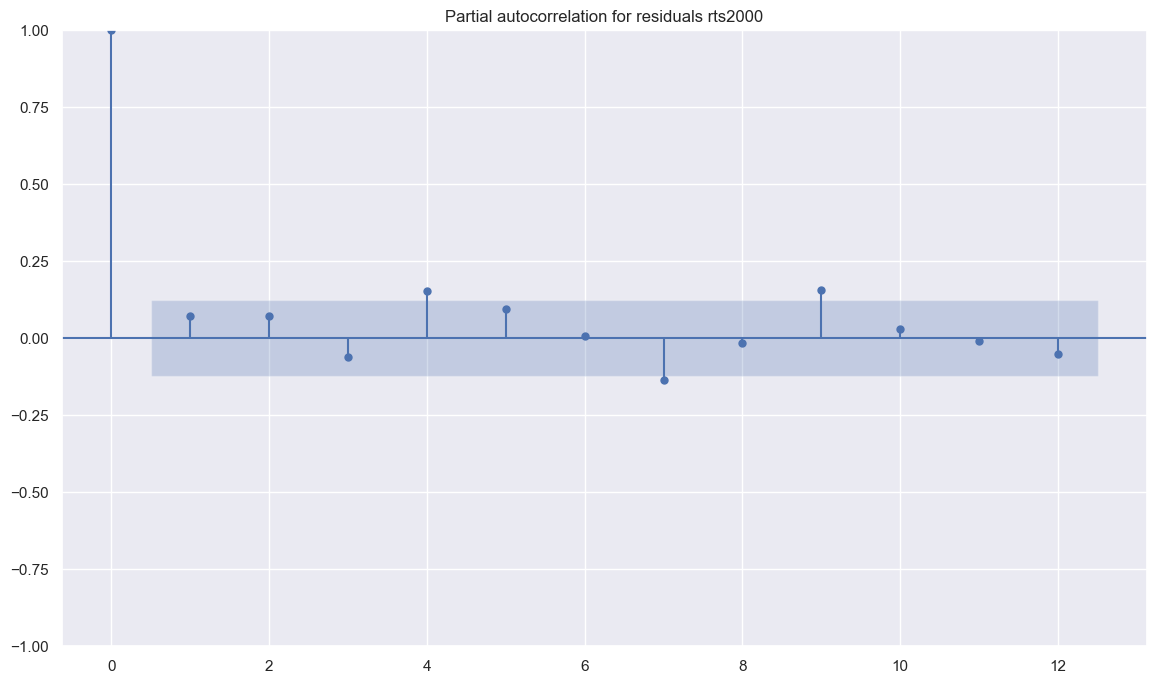

,autocorr,pacf
0,0.0704525582,0.0707366411
1,0.0744426830,0.0703940140
2,-0.0501904259,-0.0613259438
3,0.1459379803,0.1527189863
4,0.1013729479,0.0928789865
5,0.0429930672,0.0057848709
6,-0.1298437512,-0.1383065801
7,-0.0207740081,-0.0175298553
8,0.1407263873,0.1537719369
9,0.0726280436,0.0293053968


In [41]:
pacf_rts2000_resid = pd.DataFrame({'autocorr': acf(resid, nlags=12)[1:],
                            'pacf': pacf(resid, nlags=12)[1:]})
plot_pacf(resid, title='Partial autocorrelation for residuals rts2000', lags=12)
plt.show()
pacf_rts2000_resid

q = 0, оскільки ARMA(2, 0) = AR(2), то нову модель навчати не будемо

## по вихідному сигналу

p - те ж саме (1)

c:\Users\Kidma\anaconda3\envs\fullds\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


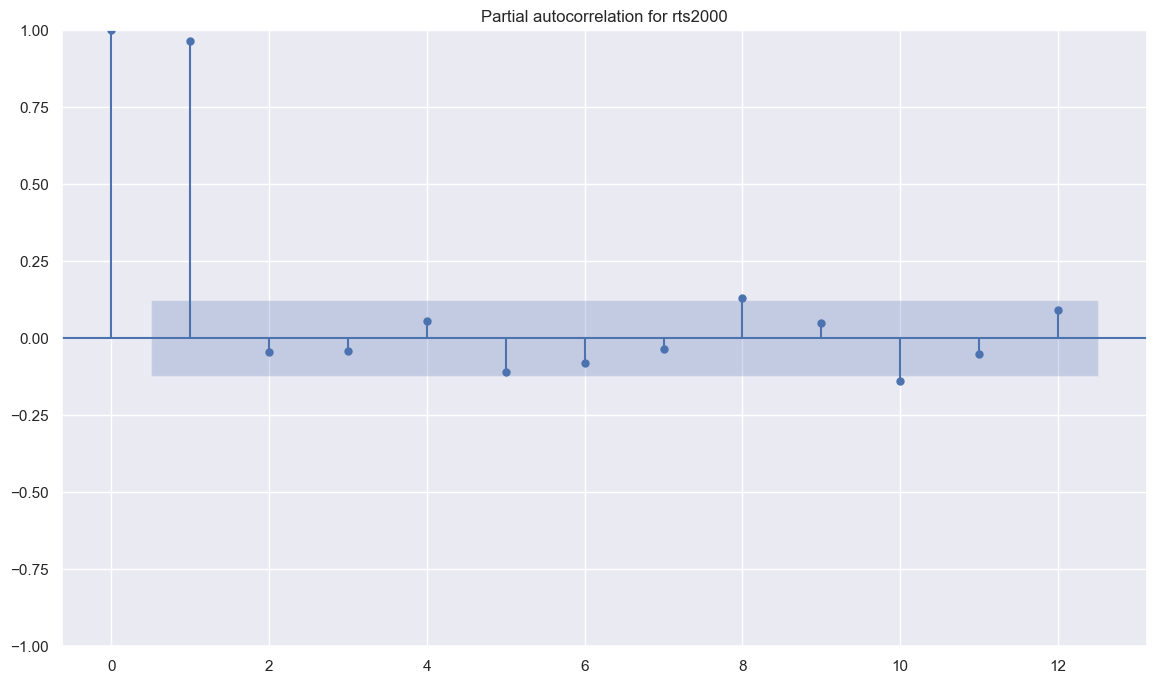

,autocorr,pacf
0,0.9600953134,0.9639511178
1,0.9186402997,-0.0445359695
2,0.8758540324,-0.0424435257
3,0.8385907641,0.0551586092
4,0.7954230446,-0.1115265231
5,0.7484247082,-0.0819898886
6,0.7001318521,-0.0368983329
7,0.6633647422,0.1298569776
8,0.6320543840,0.0491666131
9,0.5934641795,-0.1395431815


In [42]:
pacf_rts2000 = pd.DataFrame({'autocorr': acf(rts2000['rts2000'], nlags=12)[1:],
                            'pacf': pacf(rts2000, nlags=12)[1:]})
plot_pacf(rts2000, title='Partial autocorrelation for rts2000', lags=12)
plt.show()

pacf_rts2000

Створимо КС для залишків моделі

In [43]:
sma_5 = calculate_sma(resid, 5)
sma_10 = calculate_sma(resid, 10)
ema_5 = calculate_ema(resid, 5)
ema_10 = calculate_ema(resid, 10)

sma_5_1 = shift(sma_5, 1, cval=0)
sma_10_1 = shift(sma_10, 1, cval=0)
ema_5_1 = shift(ema_5, 1, cval=0)
ema_10_1 = shift(ema_10, 1, cval=0)

### q
#### sma 5

c:\Users\Kidma\anaconda3\envs\fullds\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


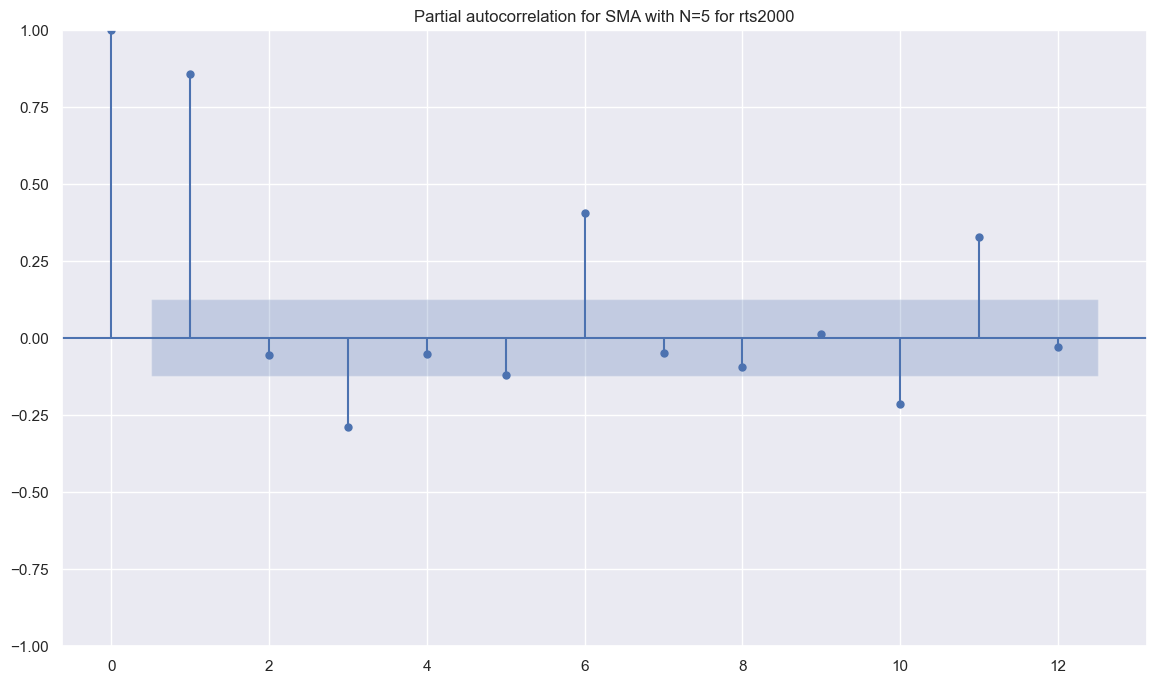

,autocorr,pacf
0,0.8516674382,0.8551578785
1,0.7108686736,-0.0542436964
2,0.5155539120,-0.2904759813
3,0.3438828152,-0.0536243248
4,0.1653715704,-0.1209408286
5,0.1266812652,0.4036133167
6,0.0848973664,-0.0499777972
7,0.0837365213,-0.0963567556
8,0.0897511153,0.0126260693
9,0.0733803528,-0.2136561062


In [44]:
pacf_rts2000 = pd.DataFrame({'autocorr': acf(sma_5[4:], nlags=12)[1:],
                            'pacf': pacf(sma_5[4:], nlags=12)[1:]})
plot_pacf(sma_5[4:], title='Partial autocorrelation for SMA with N=5 for rts2000', lags=12)
plt.show()

pacf_rts2000

q = 1

#### sma 10

c:\Users\Kidma\anaconda3\envs\fullds\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


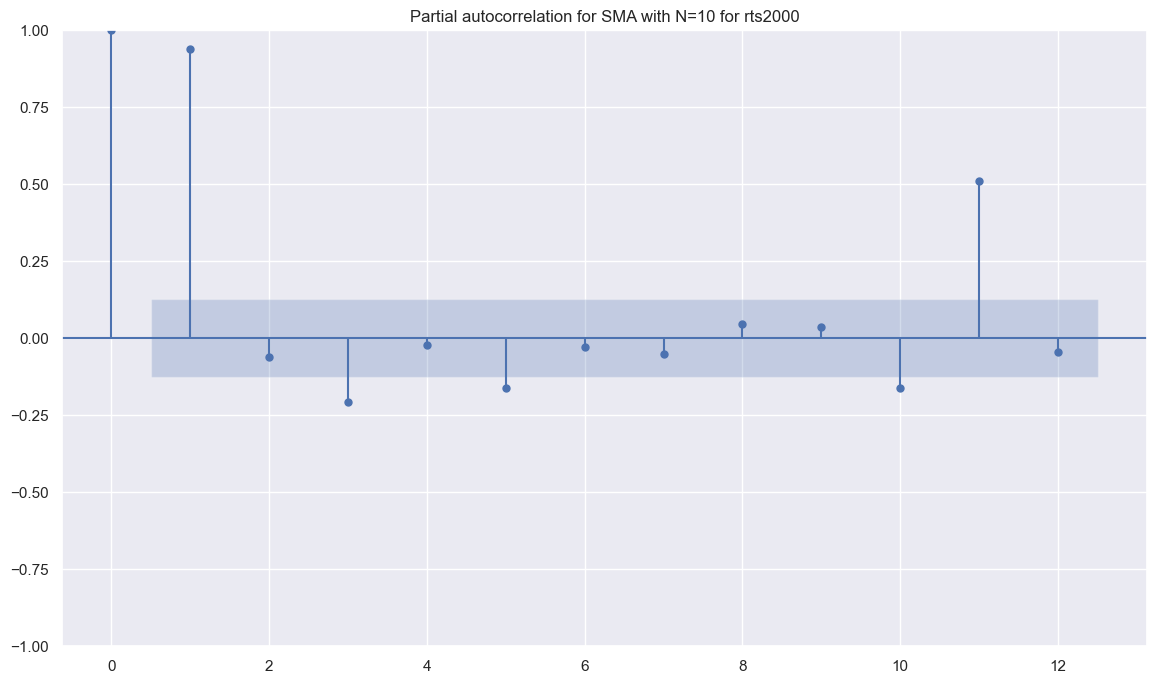

,autocorr,pacf
0,0.9344127562,0.9383224330
1,0.8656297409,-0.0631115356
2,0.7768655944,-0.2086042446
3,0.6907593588,-0.0242005836
4,0.5896465124,-0.1630941182
5,0.4934105811,-0.0305936655
6,0.3952987899,-0.0530114279
7,0.3122465768,0.0455644905
8,0.2389420569,0.0350145392
9,0.1601820204,-0.1628427713


In [45]:
pacf_rts2000 = pd.DataFrame({'autocorr': acf(sma_10[9:], nlags=12)[1:],
                            'pacf': pacf(sma_10[9:], nlags=12)[1:]})
plot_pacf(sma_10[9:], title='Partial autocorrelation for SMA with N=10 for rts2000', lags=12)
plt.show()

pacf_rts2000

q = 1

#### ema 5

c:\Users\Kidma\anaconda3\envs\fullds\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


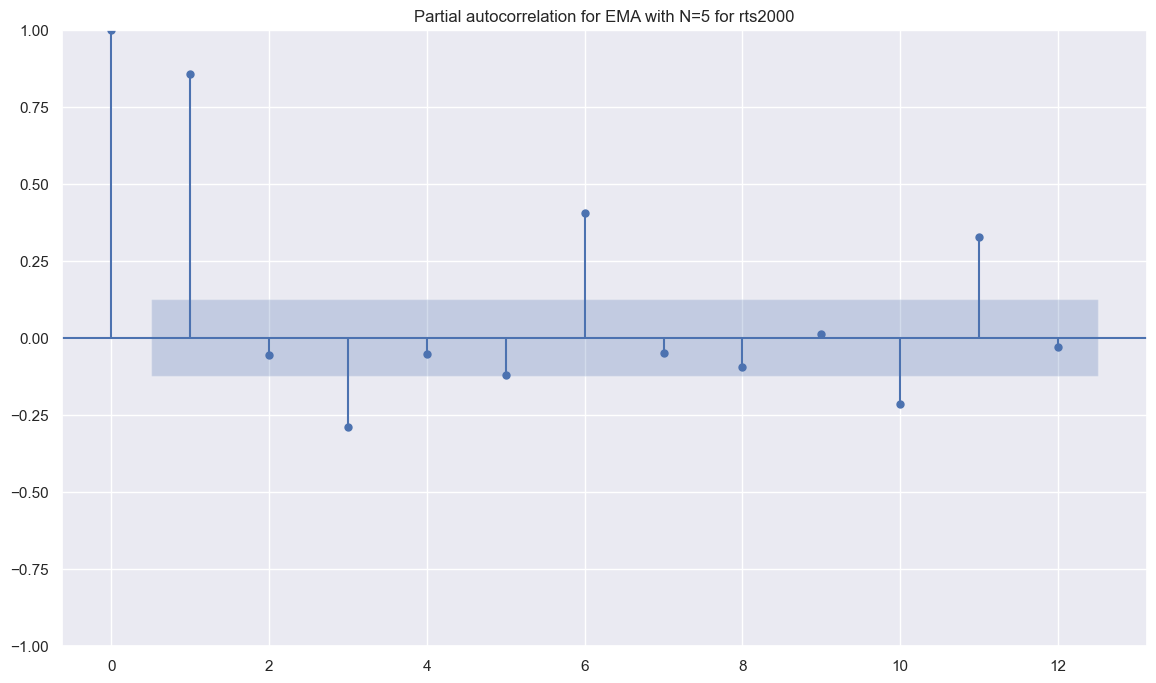

,autocorr,pacf
0,0.7429856679,0.7460306912
1,0.5548533623,0.0064456883
2,0.4071682300,-0.0163442638
3,0.3626518625,0.1463889249
4,0.2908613570,-0.0533787199
5,0.1925315222,-0.0978366591
6,0.1006411917,-0.0396576208
7,0.1112706109,0.1468943533
8,0.1489898335,0.0795997768
9,0.1248457977,-0.0902456862


In [46]:
pacf_rts2000 = pd.DataFrame({'autocorr': acf(ema_5[4:], nlags=12)[1:],
                            'pacf': pacf(ema_5[4:], nlags=12)[1:]})
plot_pacf(sma_5[4:], title='Partial autocorrelation for EMA with N=5 for rts2000', lags=12)
plt.show()

pacf_rts2000

q = 1

#### ema 10

c:\Users\Kidma\anaconda3\envs\fullds\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


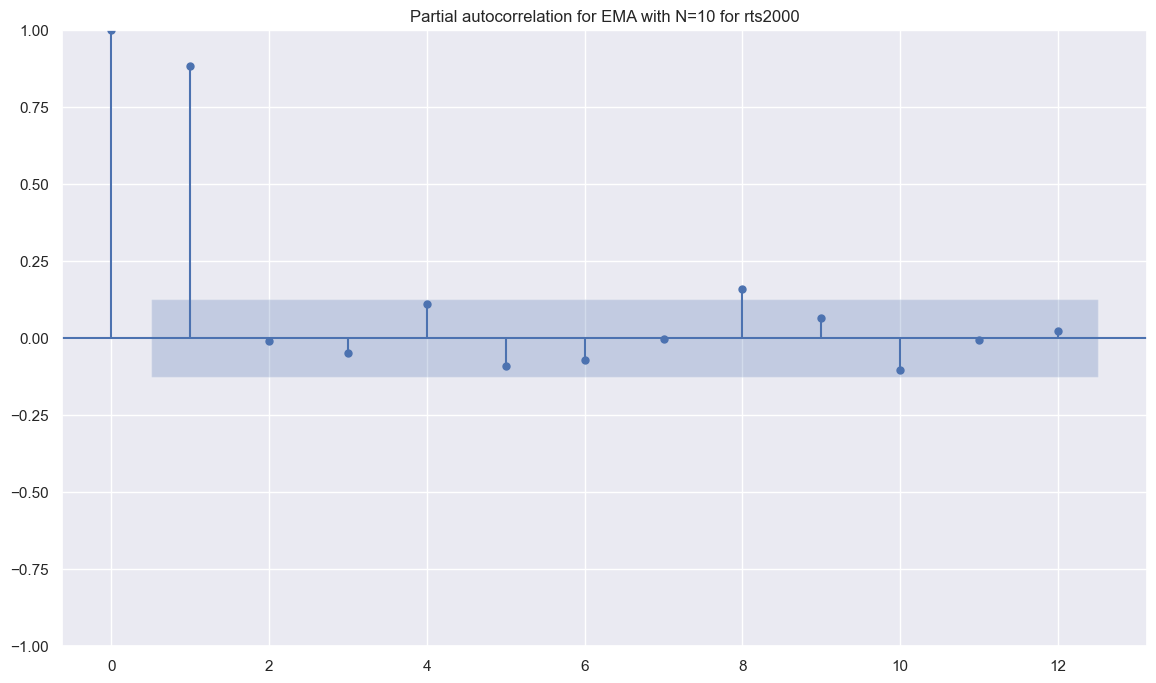

,autocorr,pacf
0,0.8772582409,0.8809287774
1,0.7670371113,-0.0113978318
2,0.6600024506,-0.0480136710
3,0.5919039251,0.1111830026
4,0.5108274637,-0.0923067558
5,0.4263895966,-0.0734440349
6,0.3488619129,-0.0052232132
7,0.3202316153,0.1574281698
8,0.3088768487,0.0641352984
9,0.2763942414,-0.1038790664


In [47]:
pacf_rts2000 = pd.DataFrame({'autocorr': acf(ema_10[9:], nlags=12)[1:],
                            'pacf': pacf(ema_10[9:], nlags=12)[1:]})
plot_pacf(ema_10[9:], title='Partial autocorrelation for EMA with N=10 for rts2000', lags=12)
plt.show()

pacf_rts2000

q = 1

Для усіх типів КС ми отримали q = 1

In [48]:
X_rts2000 = pd.DataFrame({'a_0': np.ones(len(y_k_1[1:])), 'y_k-1': y_k_1[1:],
                           'sma_5': sma_5, 'sma_5_1': sma_5_1,
                           'sma_10': sma_10, 'sma_10_1': sma_10_1,
                           'ema_5': ema_5, 'ema_5_1': ema_5_1,
                           'ema_10': ema_10, 'ema_10_1': ema_10_1})

## creating second arma models for precomputed ma values

Порахувавши ми отримали b_1=0

In [49]:
X_train_rts2000_sma_5, X_test_rts2000_sma_5, \
y_train_sma_5, y_test_sma_5, \
train_sma_5, test_sma_5 = train_test_split(X_rts2000[4:], np.subtract(rts2000.values.flatten()[5:], sma_5[4:]), sma_5[4:],
                                test_size=0.2, shuffle=False)

X_train_rts2000_sma_10, X_test_rts2000_sma_10, \
y_train_sma_10, y_test_sma_10, \
train_sma_10, test_sma_10 = train_test_split(X_rts2000[9:], np.subtract(rts2000.values.flatten()[10:], sma_10[9:]), sma_10[9:],
                                test_size=0.2, shuffle=False)

X_train_rts2000_ema_5, X_test_rts2000_ema_5, \
y_train_ema_5, y_test_ema_5, \
train_ema_5, test_ema_5 = train_test_split(X_rts2000[4:], np.subtract(rts2000.values.flatten()[5:], ema_5[4:]), ema_5[4:],
                                test_size=0.2, shuffle=False)

X_train_rts2000_ema_10, X_test_rts2000_ema_10, \
y_train_ema_10, y_test_ema_10, \
train_ema_10, test_ema_10 = train_test_split(X_rts2000[9:], np.subtract(rts2000.values.flatten()[10:], ema_5[9:]), ema_10[9:],
                                test_size=0.2, shuffle=False)

y_train_rts2000_5, y_test_rts2000_5 = train_test_split(rts2000.values.flatten()[5:], test_size=0.2, shuffle=False)
y_train_rts2000_10, y_test_rts2000_10 = train_test_split(rts2000.values.flatten()[10:], test_size=0.2, shuffle=False)

In [50]:
# sma 5
mls = MLS()

mls.fit(X_train_rts2000_sma_5[['a_0', 'y_k-1']], y_train_sma_5)

predicted = mls.predict(X_test_rts2000_sma_5[['a_0', 'y_k-1']]) + test_sma_5

results_2 = add_results(results_2, y_test_rts2000_5, predicted)

print(mls.coefs)

# sma 10
mls = MLS()

mls.fit(X_train_rts2000_sma_10[['a_0', 'y_k-1']], y_train_sma_10)

predicted = mls.predict(X_test_rts2000_sma_10[['a_0', 'y_k-1']]) + test_sma_10

results_2 = add_results(results_2, y_test_rts2000_10, predicted)

print(mls.coefs)

# ema 5
mls = MLS()

mls.fit(X_train_rts2000_ema_5[['a_0', 'y_k-1']], y_train_ema_5)

predicted = mls.predict(X_test_rts2000_ema_5[['a_0', 'y_k-1']]) + test_ema_5

results_2 = add_results(results_2, y_test_rts2000_5, predicted)

print(mls.coefs)

# ema 10
mls = MLS()

mls.fit(X_train_rts2000_ema_10[['a_0', 'y_k-1']], y_train_ema_10)

predicted = mls.predict(X_test_rts2000_ema_10[['a_0', 'y_k-1']]) + test_ema_10
results_2 = add_results(results_2, y_test_rts2000_10, predicted)

print(mls.coefs)

results_2

[array([23.93565435,  0.88152711])]
[array([25.40914638,  0.87462819])]
[array([21.51907099,  0.89342348])]
[array([21.74840226,  0.8927097 ])]


,S,R^2,IKA,DW,MSE,RMSE
0,1909.5662920310,0.8945566604,383.7315711510,1.4977785344,38.1913258406,6.1799130933
1,1551.4959117215,0.9206803506,366.0017675930,1.5102372884,31.6631818719,5.6270046980
2,1674.3916293617,0.9059852025,362.3138482528,1.3513650128,34.8831589450,5.9061966565
3,984.6260399793,0.9220166645,343.7208337978,1.6446679856,20.0944089792,4.4826787727
4,1317.6096480069,0.9342934333,350.8115760598,1.5829983883,27.4502010001,5.2392939410


## Обчислення коефіцієнтів

In [51]:
# sma 5
mls = MLS()

mls.fit(X_train_rts2000_sma_5[['a_0', 'y_k-1', 'sma_5', 'sma_5_1']], y_train_rts2000_5)

predicted = mls.predict(X_test_rts2000_sma_5[['a_0', 'y_k-1', 'sma_5', 'sma_5_1']])

results_2 = add_results(results_2, y_test_rts2000_5, predicted)

print(mls.coefs)

# sma 10
mls = MLS()

mls.fit(X_train_rts2000_sma_10[['a_0', 'y_k-1', 'sma_10', 'sma_10_1']], y_train_rts2000_10)

predicted = mls.predict(X_test_rts2000_sma_10[['a_0', 'y_k-1', 'sma_10', 'sma_10_1']])

results_2 = add_results(results_2, y_test_rts2000_10, predicted)

print(mls.coefs)

# ema 5
mls = MLS()

mls.fit(X_train_rts2000_ema_5[['a_0', 'y_k-1', 'ema_5', 'ema_5_1']], y_train_rts2000_5)

predicted = mls.predict(X_test_rts2000_ema_5[['a_0', 'y_k-1', 'ema_5', 'ema_5_1']])

results_2 = add_results(results_2, y_test_rts2000_5, predicted)

print(mls.coefs)

# ema 10
mls = MLS()

mls.fit(X_train_rts2000_ema_10[['a_0', 'y_k-1', 'ema_10', 'ema_10_1']], y_train_rts2000_10)

predicted = mls.predict(X_test_rts2000_ema_10[['a_0', 'y_k-1', 'ema_10', 'ema_10_1']]) 

results_2 = add_results(results_2, y_test_rts2000_10, predicted)

print(mls.coefs)

results_2

[array([12.42235413,  0.93852182,  2.85228193, -2.1034629 ])]
[array([16.2038973 ,  0.92023113,  5.25691171, -4.45996877])]
[array([ 9.46423224,  0.95308986,  2.98194248, -1.9910868 ])]
[array([10.15819546,  0.94985656,  5.50932522, -4.4909996 ])]


,S,R^2,IKA,DW,MSE,RMSE
0,1909.5662920310,0.8945566604,383.7315711510,1.4977785344,38.1913258406,6.1799130933
1,1551.4959117215,0.9206803506,366.0017675930,1.5102372884,31.6631818719,5.6270046980
2,1674.3916293617,0.9059852025,362.3138482528,1.3513650128,34.8831589450,5.9061966565
3,984.6260399793,0.9220166645,343.7208337978,1.6446679856,20.0944089792,4.4826787727
4,1317.6096480069,0.9342934333,350.8115760598,1.5829983883,27.4502010001,5.2392939410
5,956.7595763565,0.9786492510,342.3140545421,2.1572758595,19.5257056399,4.4187900652
6,891.7671197610,0.9509162752,332.0738410556,1.3824316949,18.5784816617,4.3102762860
7,0.1108986420,1.0004434521,-101.7577928515,0.9274811156,0.0022632376,0.0475734967
8,0.1692159518,0.9981047070,-79.2758188116,0.0367151663,0.0035253323,0.0593745091


In [52]:
idx = ['AR(1)',
       'ARMA(1, 1)_precomp_sma5', 'ARMA(1, 1)_precomp_sma10', 'ARMA(1, 1)_precomp_ema5', 'ARMA(1, 1)_precomp_ema10',
       'ARMA(1, 1)_computing_sma5', 'ARMA(1, 1)_computing_sma10', 'ARMA(1, 1)_computing_ema5', 'ARMA(1, 1)_computing_ema10']

results_2 = results_2.set_index(pd.Index(idx))

results_2

,S,R^2,IKA,DW,MSE,RMSE
AR(1),1909.5662920310,0.8945566604,383.7315711510,1.4977785344,38.1913258406,6.1799130933
"ARMA(1, 1)_precomp_sma5",1551.4959117215,0.9206803506,366.0017675930,1.5102372884,31.6631818719,5.6270046980
"ARMA(1, 1)_precomp_sma10",1674.3916293617,0.9059852025,362.3138482528,1.3513650128,34.8831589450,5.9061966565
"ARMA(1, 1)_precomp_ema5",984.6260399793,0.9220166645,343.7208337978,1.6446679856,20.0944089792,4.4826787727
"ARMA(1, 1)_precomp_ema10",1317.6096480069,0.9342934333,350.8115760598,1.5829983883,27.4502010001,5.2392939410
"ARMA(1, 1)_computing_sma5",956.7595763565,0.9786492510,342.3140545421,2.1572758595,19.5257056399,4.4187900652
"ARMA(1, 1)_computing_sma10",891.7671197610,0.9509162752,332.0738410556,1.3824316949,18.5784816617,4.3102762860
"ARMA(1, 1)_computing_ema5",0.1108986420,1.0004434521,-101.7577928515,0.9274811156,0.0022632376,0.0475734967
"ARMA(1, 1)_computing_ema10",0.1692159518,0.9981047070,-79.2758188116,0.0367151663,0.0035253323,0.0593745091


In [53]:
best_model = MLS()

best_model.fit(X_train_rts2000_ema_5[['a_0', 'y_k-1', 'ema_5', 'ema_5_1']], y_train_rts2000_5)

predicted = best_model.predict(X_test_rts2000_ema_5[['a_0', 'y_k-1', 'ema_5', 'ema_5_1']])

best_model.weights()

array([ 9.46423224,  0.95308986,  2.98194248, -1.9910868 ])

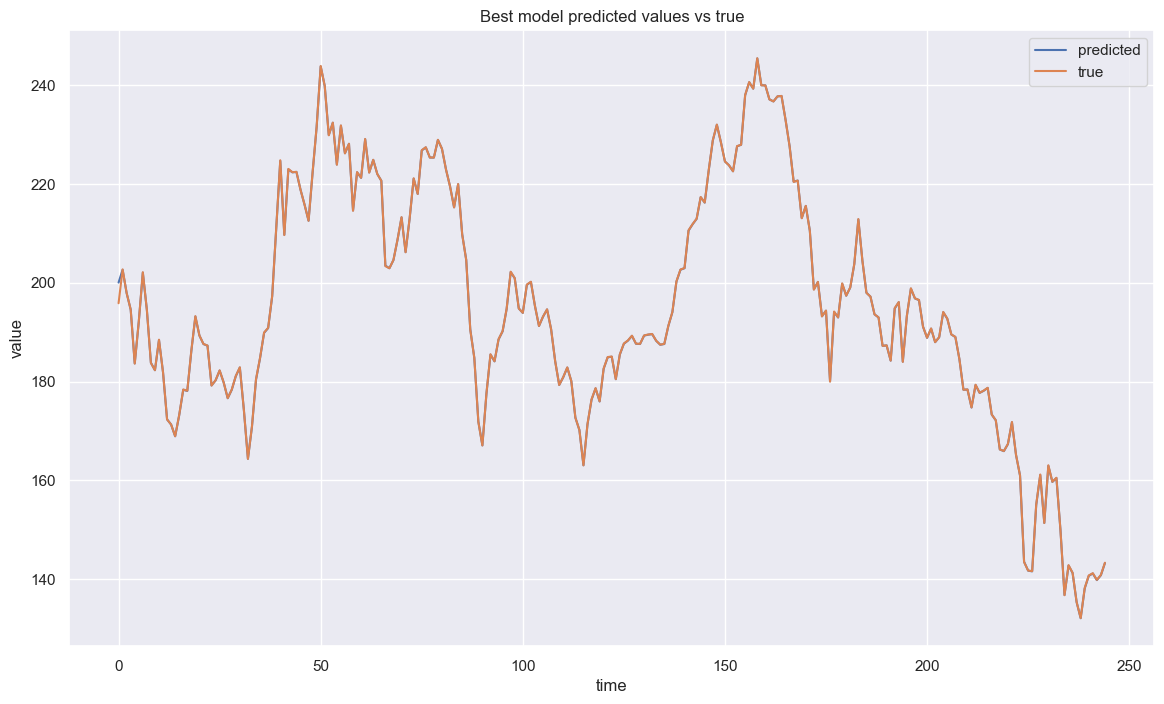

In [54]:
plt.plot(best_model.predict(X_rts2000[4:][['a_0', 'y_k-1', 'ema_5', 'ema_5_1']]), label='predicted')
plt.plot(rts2000.values.flatten()[5:], label='true')
plt.xlabel('time')
plt.ylabel('value')
plt.title('Best model predicted values vs true')
plt.legend()
plt.show()

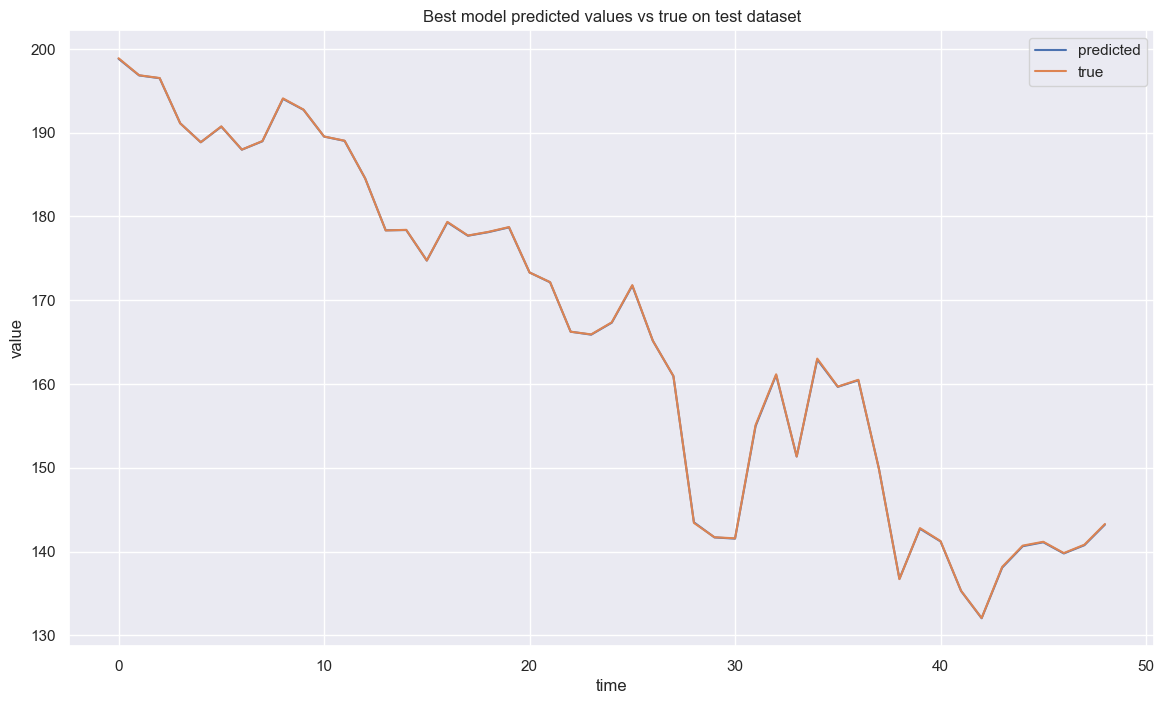

In [55]:
plt.plot(predicted, label='predicted')
plt.plot(y_test_rts2000_5, label='true')
plt.xlabel('time')
plt.ylabel('value')
plt.title('Best model predicted values vs true on test dataset')
plt.legend()
plt.show()

In [56]:
results_2.loc['ARMA(1, 1)_computing_ema5'].T

S         0.1108986420
R^2       1.0004434521
IKA    -101.7577928515
DW        0.9274811156
MSE       0.0022632376
RMSE      0.0475734967
Name: ARMA(1, 1)_computing_ema5, dtype: float64

# Mnozh regress


In [57]:
filelist = ['RTScr.txt', 'RTSeu.txt', 'RTSfn.txt', 'RTSin.txt', 'RTSmm.txt', 'RTSog.txt', 'RTStl.txt', 'rts1.txt']
full_df = pd.concat([pd.read_csv(item, names=[item[:-4]]) for item in filelist], axis=1)
full_df

,RTScr,RTSeu,RTSfn,RTSin,RTSmm,RTSog,RTStl,rts1
0,374.1200000000,465.2900000000,786.3100000000,408.6200000000,363.9700000000,288.9000000000,322.8500000000,2296.5600000000
1,376.1700000000,463.2200000000,788.7900000000,409.3300000000,368.8100000000,289.5600000000,322.5900000000,2306.8700000000
2,380.3400000000,463.9200000000,792.2700000000,413.3000000000,369.5000000000,289.2000000000,324.0900000000,2313.9000000000
3,382.7600000000,465.0900000000,796.2100000000,414.3400000000,376.5200000000,293.3000000000,328.1200000000,2339.7900000000
4,386.3700000000,468.2300000000,793.4300000000,417.9600000000,376.0500000000,291.3900000000,328.7200000000,2330.8700000000
...,...,...,...,...,...,...,...,...
173,232.8100000000,194.6800000000,377.6600000000,255.5800000000,212.2300000000,176.6900000000,181.0900000000,1277.6000000000
174,222.1800000000,173.7000000000,335.1800000000,246.1400000000,198.6200000000,153.4500000000,170.3700000000,1131.1200000000
175,216.7600000000,169.9200000000,309.3900000000,246.1400000000,198.7000000000,147.4000000000,158.3900000000,1058.8400000000
176,216.7600000000,169.9200000000,309.3900000000,246.1400000000,198.7000000000,147.4000000000,158.3900000000,1058.8400000000


<AxesSubplot: >

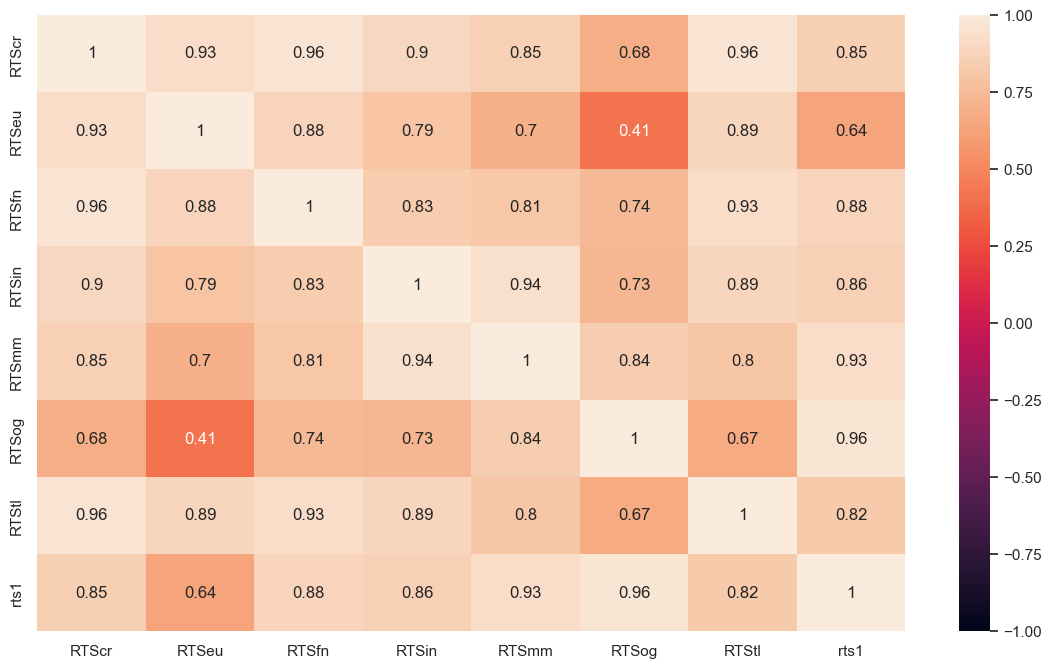

In [58]:
corr = full_df.corr()
sns.heatmap(corr, annot=True, vmin=-1, vmax=1)

Видаляємо RTSeu, воно має відносно не високу кореляцію з цільовою змінної, та високу спільну кореляцію з RTScr, також RTSin, тому що має дуже високу кореляцію з RTSmm і має меншу кореляцію з rts1, ніж RTSmm

Також спробуємо навчити на датасеті де ми нічого не видалимо

In [59]:
full_df = full_df.assign(intercept=np.ones(full_df.shape[0]))
full_df

,RTScr,RTSeu,RTSfn,RTSin,RTSmm,RTSog,RTStl,rts1,intercept
0,374.1200000000,465.2900000000,786.3100000000,408.6200000000,363.9700000000,288.9000000000,322.8500000000,2296.5600000000,1.0000000000
1,376.1700000000,463.2200000000,788.7900000000,409.3300000000,368.8100000000,289.5600000000,322.5900000000,2306.8700000000,1.0000000000
2,380.3400000000,463.9200000000,792.2700000000,413.3000000000,369.5000000000,289.2000000000,324.0900000000,2313.9000000000,1.0000000000
3,382.7600000000,465.0900000000,796.2100000000,414.3400000000,376.5200000000,293.3000000000,328.1200000000,2339.7900000000,1.0000000000
4,386.3700000000,468.2300000000,793.4300000000,417.9600000000,376.0500000000,291.3900000000,328.7200000000,2330.8700000000,1.0000000000
...,...,...,...,...,...,...,...,...,...
173,232.8100000000,194.6800000000,377.6600000000,255.5800000000,212.2300000000,176.6900000000,181.0900000000,1277.6000000000,1.0000000000
174,222.1800000000,173.7000000000,335.1800000000,246.1400000000,198.6200000000,153.4500000000,170.3700000000,1131.1200000000,1.0000000000
175,216.7600000000,169.9200000000,309.3900000000,246.1400000000,198.7000000000,147.4000000000,158.3900000000,1058.8400000000,1.0000000000
176,216.7600000000,169.9200000000,309.3900000000,246.1400000000,198.7000000000,147.4000000000,158.3900000000,1058.8400000000,1.0000000000


In [60]:
X_train_dim_rts1, X_test_dim_rts1, y_train_rts1, y_test_rts1 = train_test_split(full_df[['RTScr', 'RTSfn', 'RTSmm', 'RTSog', 'RTStl', 'intercept']],
                                                                        full_df['rts1'], test_size=0.2, shuffle=False)

X_train_rts1, X_test_rts1 = train_test_split(full_df[['RTScr', 'RTSfn', 'RTSmm', 'RTSog', 'RTStl', 'RTSin', 'RTSeu', 'intercept']], test_size=0.2, shuffle=False)

In [61]:
mls = MLS()

mls.fit(X_train_rts1, y_train_rts1)

predicted = mls.predict(X_test_rts1)

results_3 = add_results(results_3, y_test_rts1, predicted)

# dim
mls = MLS()

mls.fit(X_train_dim_rts1, y_train_rts1)

predicted = mls.predict(X_test_dim_rts1)

results_3 = add_results(results_3, y_test_rts1, predicted)

results_3 = results_3.set_index(pd.Index(['Full dataset', 'Diminished dataset']))

print(mls.coefs)

results_3

[array([-0.3142078 ,  0.79659766,  1.09716086,  4.14991048,  0.45945238,
       38.68254197])]


,S,R^2,IKA,DW,MSE,RMSE
Full dataset,79133.6145786121,0.8767038256,412.0401489559,0.0306848317,2198.1559605170,46.8844959503
Diminished dataset,29533.0205137063,0.9066207975,376.5575132082,0.0825426332,820.3616809363,28.6419566534


In [62]:
X_train_dim_rts1

,RTScr,RTSfn,RTSmm,RTSog,RTStl,intercept
0,374.1200000000,786.3100000000,363.9700000000,288.9000000000,322.8500000000,1.0000000000
1,376.1700000000,788.7900000000,368.8100000000,289.5600000000,322.5900000000,1.0000000000
2,380.3400000000,792.2700000000,369.5000000000,289.2000000000,324.0900000000,1.0000000000
3,382.7600000000,796.2100000000,376.5200000000,293.3000000000,328.1200000000,1.0000000000
4,386.3700000000,793.4300000000,376.0500000000,291.3900000000,328.7200000000,1.0000000000
...,...,...,...,...,...,...
137,309.2400000000,600.0300000000,311.9800000000,258.6100000000,252.1900000000,1.0000000000
138,311.0400000000,596.0700000000,301.6800000000,256.4000000000,250.7000000000,1.0000000000
139,309.9600000000,580.8900000000,297.5700000000,254.3400000000,244.5600000000,1.0000000000
140,308.9700000000,595.8000000000,310.4500000000,259.4700000000,248.2400000000,1.0000000000


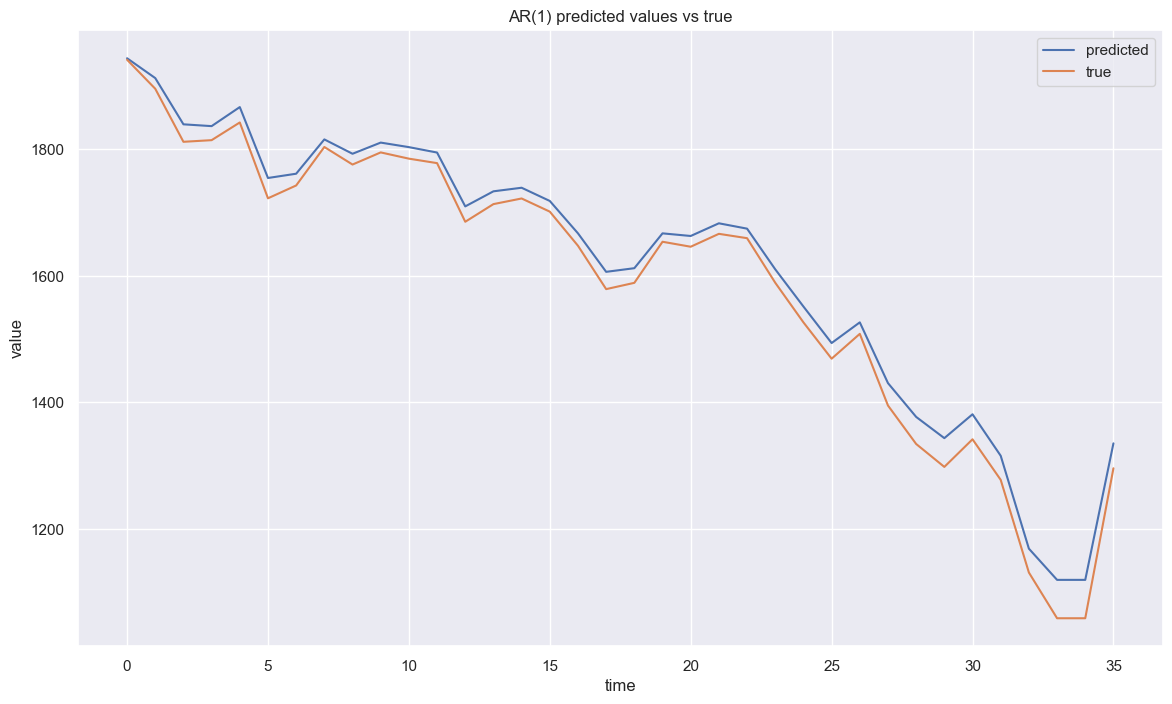

In [63]:
plt.plot(predicted, label='predicted')
plt.plot(y_test_rts1.values, label='true')
plt.xlabel('time')
plt.ylabel('value')
plt.title('AR(1) predicted values vs true')
plt.legend()
plt.show()

In [64]:
results_3.T

,Full dataset,Diminished dataset
S,79133.6145786121,29533.0205137063
R^2,0.8767038256,0.9066207975
IKA,412.0401489559,376.5575132082
DW,0.0306848317,0.0825426332
MSE,2198.1559605170,820.3616809363
RMSE,46.8844959503,28.6419566534
